In [1]:
import sys
print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on October 31 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)  

In [3]:
import numpy as np

In [4]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [5]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

In [7]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

### 'unit test'

In [8]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  




sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.07,-0.2,
                                 0.7,1,-0.2,0.00,
                                 0.1,-0.4,0.90,
                                 0.10,0.91,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
#assert res=-4808.04
#print('ok')

version of the code is: 0.13b
-4560.475288095065


In [9]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

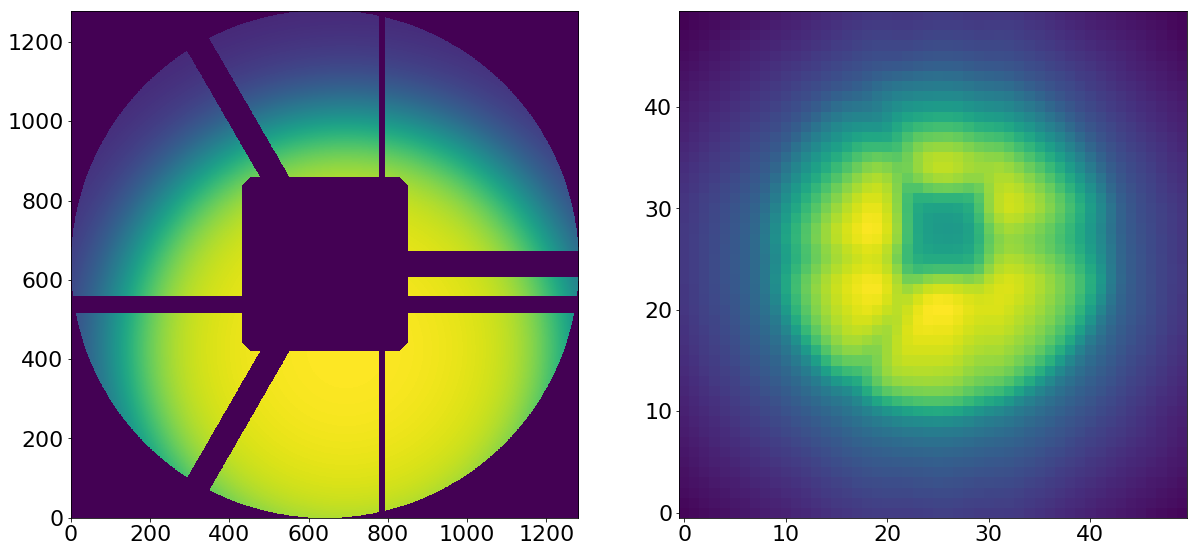

In [10]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

# Analysis (Single)

## Creating results_of_fit_many_interpolation_preOctoberrun

In [462]:
import pickle
DATA_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Oct2018/'
with open(DATA_FOLDER + 'results_of_fit_many_interpolation_preOctoberrun.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preOctoberrun=pickle.load(f)
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

In [463]:
for i in label:
    results_of_fit_many_interpolation_preOctoberrun[i]['scattering_radius']=np.full(100,0.5)

In [470]:
columns_pre_extended=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','frd_lorentz_factor','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns_extended=np.concatenate((columns_pre_extended,['chi2', 'chi2max']),axis=0)

columns_extended_new=np.concatenate((columns,['chi2', 'chi2max']),axis=0)

In [467]:
for i in label:
    results_of_fit_many_interpolation_preOctoberrun[i].columns=columns_extended

In [471]:
for i in label:
    results_of_fit_many_interpolation_preOctoberrun[i]=results_of_fit_many_interpolation_preOctoberrun[i][columns_extended_new]

In [788]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov032018/' + 'results_of_fit_many_interpolation_preNovemberrun.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_preOctoberrun,f, protocol=pickle.HIGHEST_PROTOCOL)

## Scripts

### defocused I

In [474]:
#MPI
for single_spot in [2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Nov.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 14:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8600,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI.py "+str(obs)+" "+str(single_spot)+" 60 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/NovScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97]:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(single_spot)+'Nov.sh \n')

        
file.close()

In [476]:
#MPI
for single_spot in [0,1,8,9,90,91,98,99,6,26,36,46,56,76,86,96]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(1)+'S'+str(single_spot)+'Nov.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=6 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8600,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI.py "+str(obs)+" "+str(single_spot)+" 60 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/NovScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [0,1,8,9,90,91,98,99,6,26,36,46,56,76,86,96]:
    file.write('sbatch /home/ncaplar/Scripts/P'+str(1)+'S'+str(single_spot)+'Nov.sh \n')

        
file.close()

### focused I

In [1186]:
print(len(np.array([2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97])))
list_split=np.split(np.array([2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97]),20)

40


In [1187]:
#MPI
for i in range(20):

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(i)+'Nov.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 5:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    single_spot=list_split[i][0]
    for obs in [8600,8606,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    single_spot=list_split[i][1]
    for obs in [8600,8606,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/NovScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(20):
    file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(i)+'Nov.sh \n')

        
file.close()

In [811]:
#MPI

list_split=np.split(np.array([0,1,8,9,90,91,98,99,6,26,36,46,56,76,86,96]),4)

for i in range(4):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(1)+'S'+str(i)+'Nov.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=6 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    single_spot=list_split[i][0]
    for obs in [8600,8606,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    single_spot=list_split[i][1]
    for obs in [8600,8606,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    single_spot=list_split[i][2]    
    for obs in [8600,8606,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    single_spot=list_split[i][3]
    for obs in [8600,8606,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/NovScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(4):
    file.write('sbatch /home/ncaplar/Scripts/P'+str(1)+'S'+str(i)+'Nov.sh \n')

        
file.close()

## Analysis of the defocused data

###  Core Analysis (pandas dataframe creation)

#### Defocus plots 

In [42]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    for var_number in range(len(columns)):
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except IndexError:
            if var_number!=25:
                print(columns[var_number]+': failed!')
                minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)
    
    
import scipy.optimize as optimize
def curve_fit_custom_lin(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a,b=V
    yfit=lin_fit_1D(index_arr,a,b)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2

def curve_fit_custom_con(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a=V
    yfit=lin_fit_1DConstant(index_arr,a)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2 

In [43]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']   

columns_analysis=columns+['chi2','chi2max']

columns_multi=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
                      'minorAxis','pupilAngle','effective_radius_illumination', 'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
                      'grating_lines','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']  

In [44]:
def create_results_of_fit_single(date,single_number):
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
            else:       
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [732]:
def solution_at_0_and_plots(date,single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper):
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=3:
        solution_at_0=np.full(31,0)
        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:
            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr_err)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]

            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            interim_zero_solutions=[]
            if q in columns[:8]:
                # these variables are fit via linear fit, without values at focus
                # it is z4-z11
                # for loop below removes 2 points from the fit that create largerst deviations from median result in focus
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,lin_fit_1D(0,popt[0],popt[1])])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                #print(good_index)
                #print(index_arr_no0)
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            interim_zero_solutions=[]
            if q in columns[8:25]:
                # these variables are set at mean value (constant fit), without values at focus
                # these are variables that describe the pupil
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,popt[0]])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[25:]),np.array(['chi2','chi2max'])),axis=0):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######

            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(single_number))

            plt.close()   
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

In [733]:
for i in range(100):
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Nov03',i)
    solution_at_0=solution_at_0_and_plots('Nov03',i,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper)

0 obs (Emcee3): 8552 is found!
0 obs (Emcee3): 8555 is found!
z11: failed!
y_ilum: failed!
z11: failed!
y_ilum: failed!
0 obs (Emcee3): 8558 is found!
frd_sigma: failed!
frd_sigma: failed!
0 8561 is NOT found or failed!
0 8564 is NOT found or failed!
0 obs (Emcee3): 8567 is found!
0 8570 is NOT found or failed!
0 obs (Emcee3): 8573 is found!
0 obs (Emcee3): 8600 is found!
0 obs (Emcee3): 8603 is found!
0 obs (Emcee3): 8606 is found!
0 8609 is NOT found or failed!
0 obs (Emcee3): 8612 is found!
0 8615 is NOT found or failed!
0 8618 is NOT found or failed!
0 obs (Emcee3): 8621 is found!
0 obs (Emcee3): 8624 is found!
0 obs (Emcee3): 8627 is found!
1 obs (Emcee3): 8552 is found!
1 obs (Emcee3): 8555 is found!
1 obs (Emcee3): 8558 is found!
1 8561 is NOT found or failed!
1 8564 is NOT found or failed!
1 obs (Emcee3): 8567 is found!
1 8570 is NOT found or failed!
1 obs (Emcee3): 8573 is found!
1 obs (Emcee3): 8600 is found!
1 obs (Emcee3): 8603 is found!
1 obs (Emcee3): 8606 is found!
1 860

22 obs (Emcee3): 8552 is found!
22 obs (Emcee3): 8555 is found!
22 obs (Emcee3): 8558 is found!
22 8561 is NOT found or failed!
22 8564 is NOT found or failed!
22 obs (Emcee3): 8567 is found!
frd_sigma: failed!
scattering_amplitude: failed!
pixel_effect: failed!
frd_sigma: failed!
scattering_amplitude: failed!
pixel_effect: failed!
22 8570 is NOT found or failed!
22 obs (Emcee3): 8573 is found!
22 obs (Emcee3): 8600 is found!
22 obs (Emcee3): 8603 is found!
22 obs (Emcee3): 8606 is found!
22 8609 is NOT found or failed!
22 obs (Emcee3): 8612 is found!
slitFrac: failed!
slitFrac: failed!
22 8615 is NOT found or failed!
22 8618 is NOT found or failed!
22 obs (Emcee3): 8621 is found!
22 obs (Emcee3): 8624 is found!
22 obs (Emcee3): 8627 is found!
23 obs (Emcee3): 8552 is found!
23 obs (Emcee3): 8555 is found!
23 obs (Emcee3): 8558 is found!
23 8561 is NOT found or failed!
23 8564 is NOT found or failed!
23 obs (Emcee3): 8567 is found!
z5: failed!
z8: failed!
frd_sigma: failed!
z5: failed!

35 obs (Emcee3): 8603 is found!
35 obs (Emcee3): 8606 is found!
35 8609 is NOT found or failed!
35 obs (Emcee3): 8612 is found!
35 8615 is NOT found or failed!
35 8618 is NOT found or failed!
35 obs (Emcee3): 8621 is found!
35 obs (Emcee3): 8624 is found!
35 obs (Emcee3): 8627 is found!
36 8552 is NOT found or failed!
36obs (Emcee2): 8555 is found!
36 8558 is NOT found or failed!
36 8561 is NOT found or failed!
36 8564 is NOT found or failed!
36 8567 is NOT found or failed!
36 8570 is NOT found or failed!
36 8573 is NOT found or failed!
36 8600 is NOT found or failed!
36 8603 is NOT found or failed!
36 8606 is NOT found or failed!
36 8609 is NOT found or failed!
36 8612 is NOT found or failed!
36 8615 is NOT found or failed!
36 8618 is NOT found or failed!
36 8621 is NOT found or failed!
36 8624 is NOT found or failed!
36 8627 is NOT found or failed!
37 obs (Emcee3): 8552 is found!
37 obs (Emcee3): 8555 is found!
37 obs (Emcee3): 8558 is found!
37 8561 is NOT found or failed!
37 8564 i

52 obs (Emcee3): 8555 is found!
52 obs (Emcee3): 8558 is found!
52 8561 is NOT found or failed!
52 8564 is NOT found or failed!
52 obs (Emcee3): 8567 is found!
52 8570 is NOT found or failed!
52 obs (Emcee3): 8573 is found!
52 obs (Emcee3): 8600 is found!
52 obs (Emcee3): 8603 is found!
52 obs (Emcee3): 8606 is found!
52 8609 is NOT found or failed!
52 obs (Emcee3): 8612 is found!
52 8615 is NOT found or failed!
52 8618 is NOT found or failed!
52 obs (Emcee3): 8621 is found!
52 obs (Emcee3): 8624 is found!
52 obs (Emcee3): 8627 is found!
53 obs (Emcee3): 8552 is found!
53 obs (Emcee3): 8555 is found!
53 obs (Emcee3): 8558 is found!
53 8561 is NOT found or failed!
53 8564 is NOT found or failed!
53 obs (Emcee3): 8567 is found!
53 8570 is NOT found or failed!
53 obs (Emcee3): 8573 is found!
53 obs (Emcee3): 8600 is found!
53 obs (Emcee3): 8603 is found!
53 obs (Emcee3): 8606 is found!
53 8609 is NOT found or failed!
53 obs (Emcee3): 8612 is found!
53 8615 is NOT found or failed!
53 8618 

72 obs (Emcee3): 8555 is found!
72 obs (Emcee3): 8558 is found!
x_ilum: failed!
x_ilum: failed!
72 8561 is NOT found or failed!
72 8564 is NOT found or failed!
72 obs (Emcee3): 8567 is found!
slitHolder_frac_dx: failed!
slitHolder_frac_dx: failed!
72 8570 is NOT found or failed!
72 obs (Emcee3): 8573 is found!
dyFocal: failed!
x_ilum: failed!
y_fiber: failed!
dyFocal: failed!
x_ilum: failed!
y_fiber: failed!
72 obs (Emcee3): 8600 is found!
72 obs (Emcee3): 8603 is found!
72 obs (Emcee3): 8606 is found!
72 8609 is NOT found or failed!
72 obs (Emcee3): 8612 is found!
72 8615 is NOT found or failed!
72 8618 is NOT found or failed!
72 obs (Emcee3): 8621 is found!
72 obs (Emcee3): 8624 is found!
72 obs (Emcee3): 8627 is found!
73 obs (Emcee3): 8552 is found!
73 obs (Emcee3): 8555 is found!
73 obs (Emcee3): 8558 is found!
73 8561 is NOT found or failed!
73 8564 is NOT found or failed!
73 obs (Emcee3): 8567 is found!
73 8570 is NOT found or failed!
73 obs (Emcee3): 8573 is found!
73 obs (Emce

85 obs (Emcee3): 8558 is found!
85 8561 is NOT found or failed!
85 8564 is NOT found or failed!
85 obs (Emcee3): 8567 is found!
85 8570 is NOT found or failed!
85 obs (Emcee3): 8573 is found!
85 obs (Emcee3): 8600 is found!
85 obs (Emcee3): 8603 is found!
85 obs (Emcee3): 8606 is found!
85 8609 is NOT found or failed!
85 obs (Emcee3): 8612 is found!
85 8615 is NOT found or failed!
85 8618 is NOT found or failed!
85 obs (Emcee3): 8621 is found!
85 obs (Emcee3): 8624 is found!
85 obs (Emcee3): 8627 is found!
86 8552 is NOT found or failed!
86 obs (Emcee3): 8555 is found!
86 8558 is NOT found or failed!
86 8561 is NOT found or failed!
86 8564 is NOT found or failed!
86 8567 is NOT found or failed!
86 8570 is NOT found or failed!
86 8573 is NOT found or failed!
86 8600 is NOT found or failed!
86 8603 is NOT found or failed!
86 8606 is NOT found or failed!
86 8609 is NOT found or failed!
86 8612 is NOT found or failed!
86 8615 is NOT found or failed!
86 8618 is NOT found or failed!
86 8621 

98 8615 is NOT found or failed!
98 8618 is NOT found or failed!
98 obs (Emcee3): 8621 is found!
z4: failed!
strutFrac: failed!
frd_sigma: failed!
scattering_amplitude: failed!
z4: failed!
strutFrac: failed!
frd_sigma: failed!
scattering_amplitude: failed!
98 obs (Emcee3): 8624 is found!
98 obs (Emcee3): 8627 is found!
99 obs (Emcee3): 8552 is found!
99 obs (Emcee3): 8555 is found!
99 8558 is NOT found or failed!
99 8561 is NOT found or failed!
99 8564 is NOT found or failed!
99 obs (Emcee3): 8567 is found!
99 8570 is NOT found or failed!
99 obs (Emcee3): 8573 is found!
99 obs (Emcee3): 8600 is found!
99 obs (Emcee3): 8603 is found!
99 obs (Emcee3): 8606 is found!
99 8609 is NOT found or failed!
99 obs (Emcee3): 8612 is found!
99 8615 is NOT found or failed!
99 8618 is NOT found or failed!
99 8621 is NOT found or failed!
99 obs (Emcee3): 8624 is found!
99obs (Emcee2): 8627 is found!


### Look at the results at one point  - defocused analysis

In [179]:
for filename in os.listdir("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov03/"):
    if filename.startswith("likechainO"):
        os.rename("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov03/"+filename,"/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov03/"+filename[:9]+filename[10:])

In [182]:
obs='8627'
single_number='55'
image_index=int(single_number)
eps=5
#date='Sep27'
date='Nov03'

obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

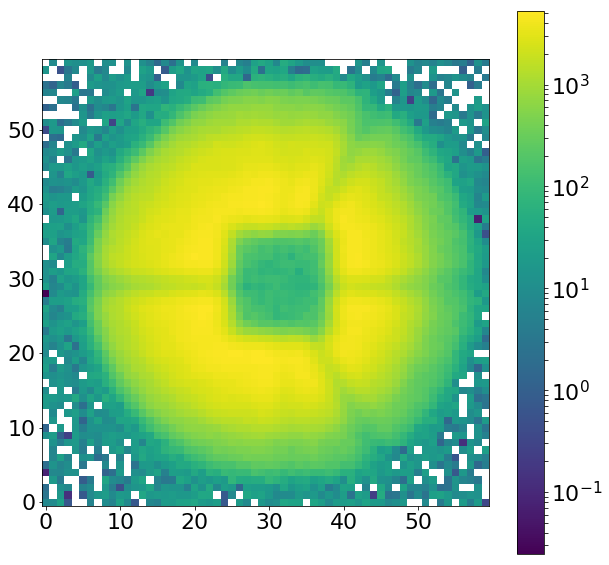

In [183]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm(),origin='lower')
plt.colorbar()

In [184]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 60, 31)
minimal likelihood is: 10616.145916601161
minimal chi2 reduced is: 5.89316356547726


In [185]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

          z4        z5        z6       z7        z8        z9       z10  \
0 -32.102484  0.021449  0.590953 -0.59186  0.059133 -0.160665 -0.323961   

        z11  
0 -0.334527  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.626298   0.070007  0.030076  0.098758  0.057934     0.142991   

   radiometricEffect  radiometricExponent   x_ilum    y_ilum  
0           0.410754             1.933019  0.00528  0.399924  
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0  0.145678 -0.026957                       0.844775   0.087072   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.999914  0.997983            0.004895  119978.316508   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r     flux  
0          2.998644              0.037843      0.366135  1.892998  0.99508  


In [186]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

          z4        z5        z6       z7        z8        z9       z10  \
0 -32.102484  0.021449  0.590953 -0.59186  0.059133 -0.160665 -0.323961   

        z11  
0 -0.334527  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.626298   0.070007  0.030076  0.098758  0.057934     0.142991   

   radiometricEffect  radiometricExponent   x_ilum    y_ilum  
0           0.410754             1.933019  0.00528  0.399924  
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0  0.145678 -0.026957                       0.844775   0.087072   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.999914  0.997983            0.004895  119978.316508   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r     flux  
0          2.998644              0.037843      0.366135  1.892998  0.99508  


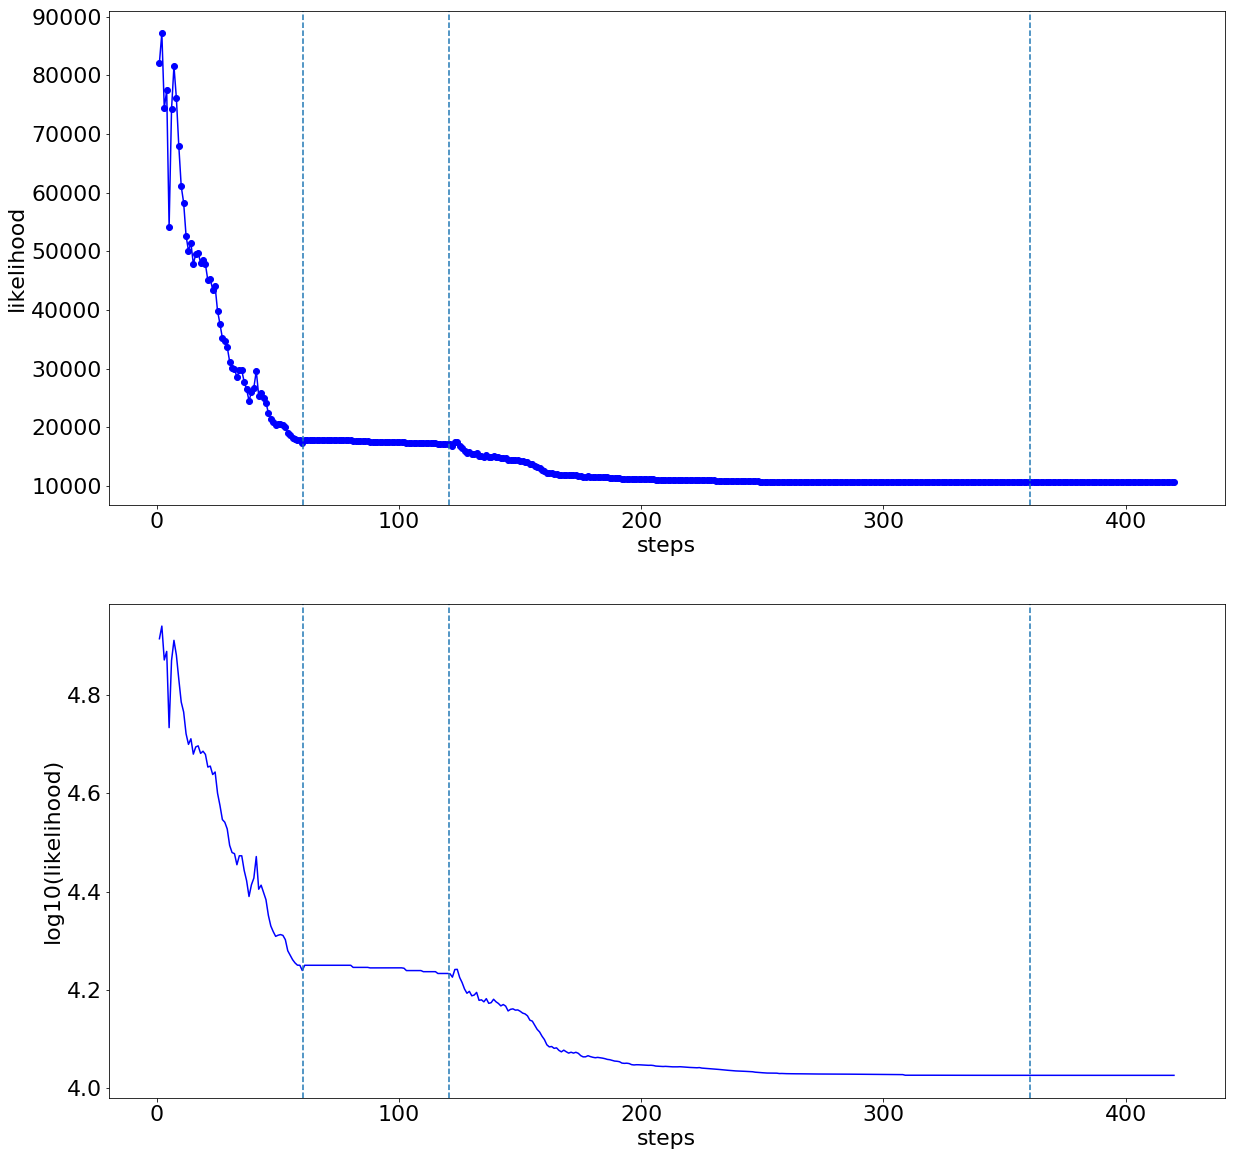

In [187]:
size=60

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*6+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(6*size+0.5,ls='--')

In [188]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)
#model(allparameters_proposal)

-10662.91407617666

In [189]:
minchain

array([   -32.10248368,      0.02144888,      0.59095262,     -0.59186049,
            0.05913324,     -0.16066517,     -0.32396051,     -0.33452696,
            0.62629767,      0.0700068 ,      0.03007565,      0.09875781,
            0.05793389,      0.14299083,      0.41075444,      1.93301903,
            0.00528023,      0.39992405,      0.14567779,     -0.02695717,
            0.84477541,      0.08707163,      0.99991436,      0.99798304,
            0.00489485, 119978.31650845,      2.99864434,      0.03784259,
            0.36613548,      1.89299806,      0.99508004])

In [190]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')          

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

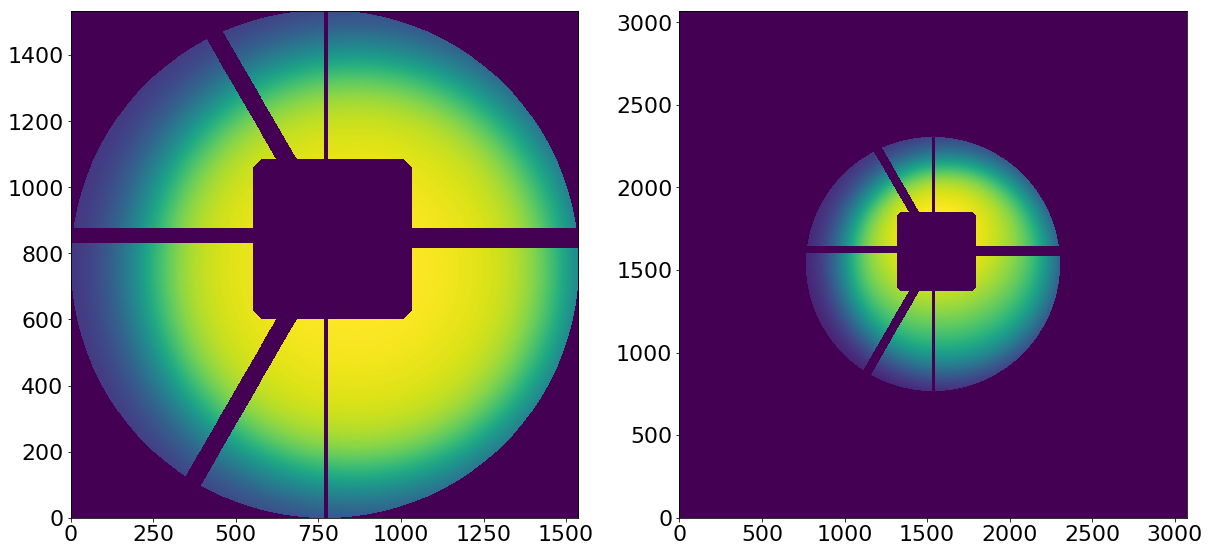

In [191]:
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
plt.subplot(122)
plt.imshow(ilum_radiometric,origin='lower')

chi**2 reduced is: 5.919145883317517
Abs of residual divided by total flux is: 0.05427650684456186
Abs of residual divided by largest value of a flux in the image is: 0.13422751609225372


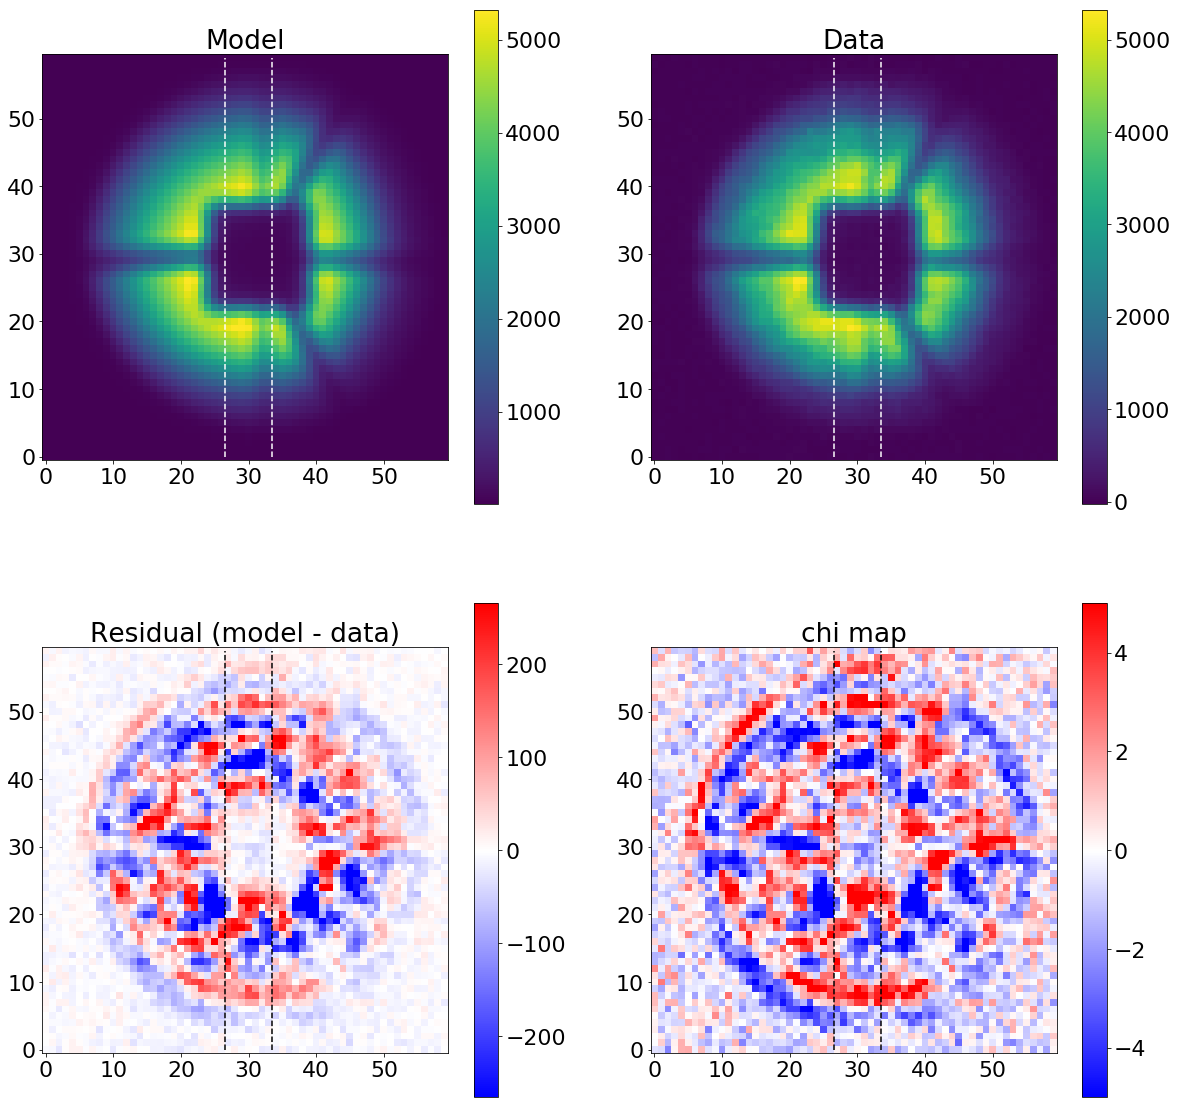

In [192]:
single_analysis.create_basic_comparison_plot()

5.919145883317517
chi**2 reduced is: 5.919145883317517
Abs of residual divided by total flux is: 0.05427650684456186
Abs of residual divided by largest value of a flux in the image is: 0.13422751609225372


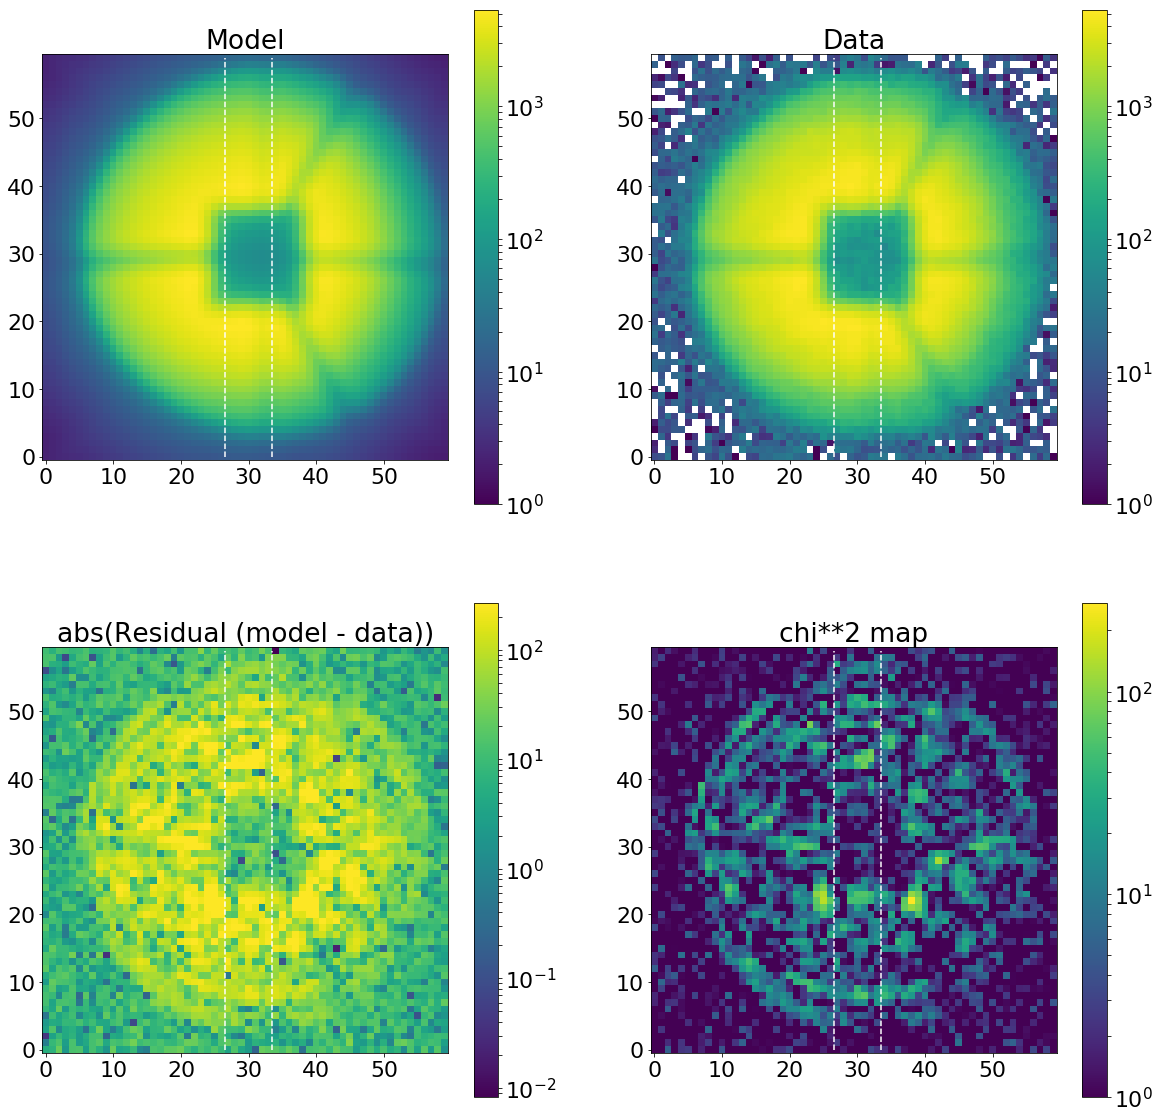

In [193]:
single_analysis.create_basic_comparison_plot_log()

5.919145883317517


0.05427650684456186

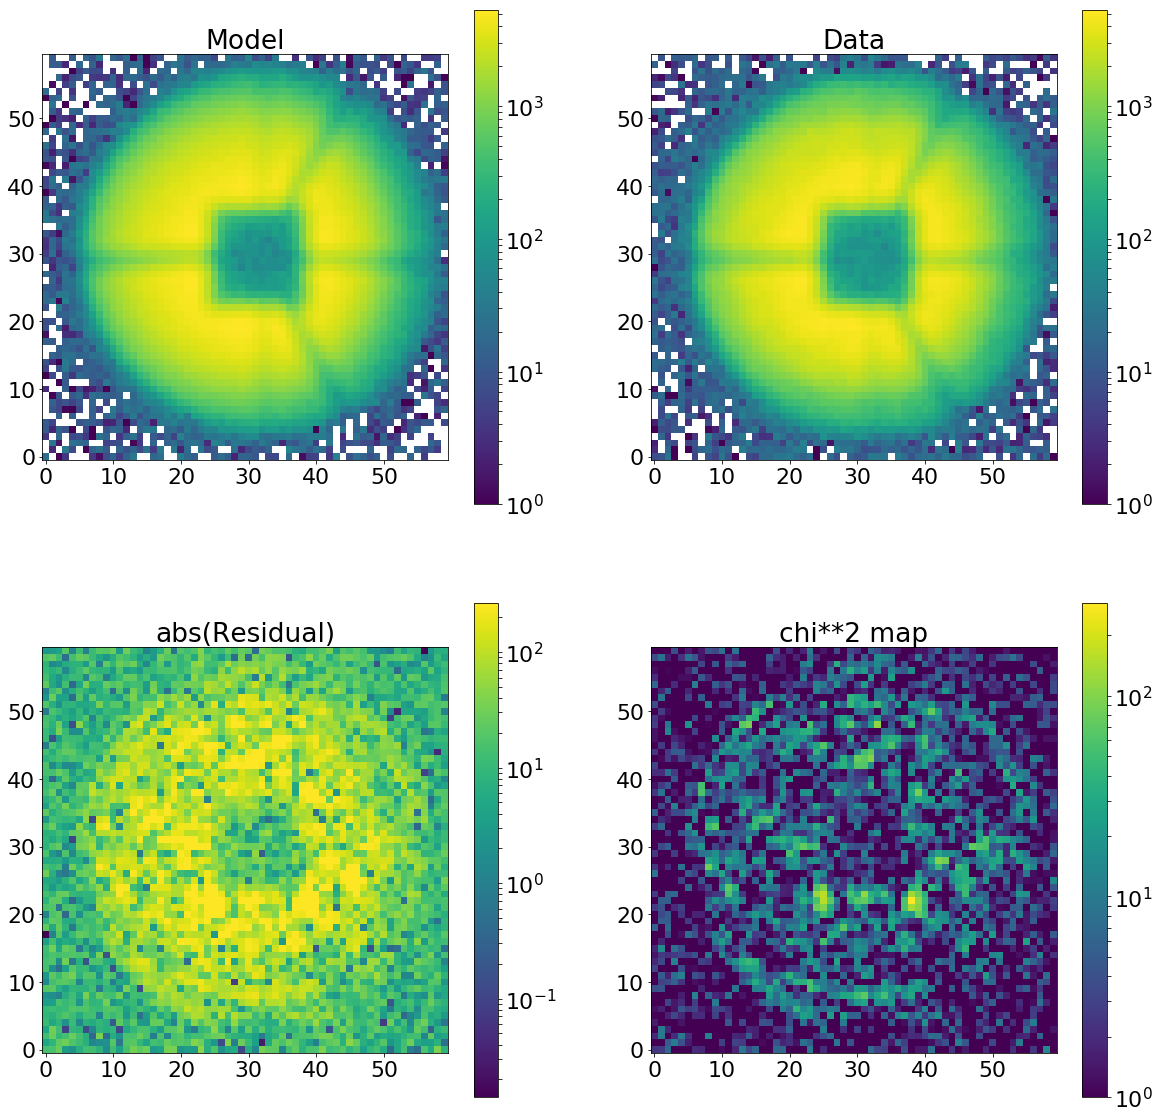

In [194]:
artifical_noise=single_analysis.create_artificial_noise()
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

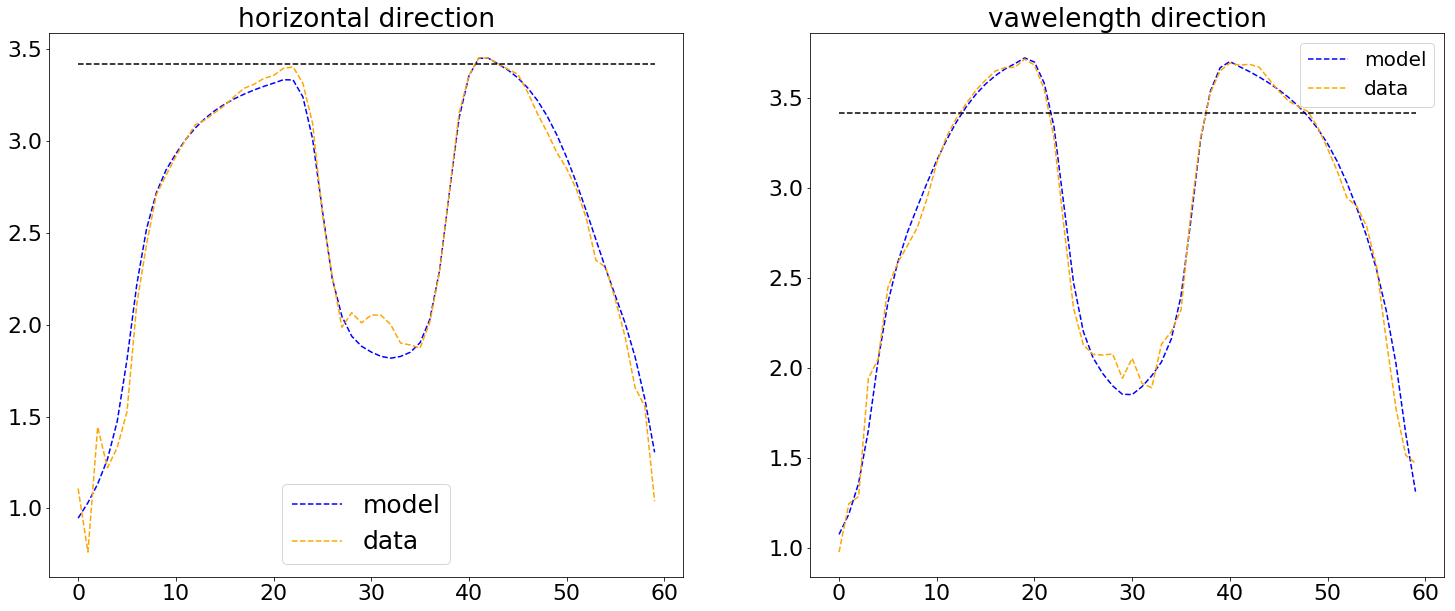

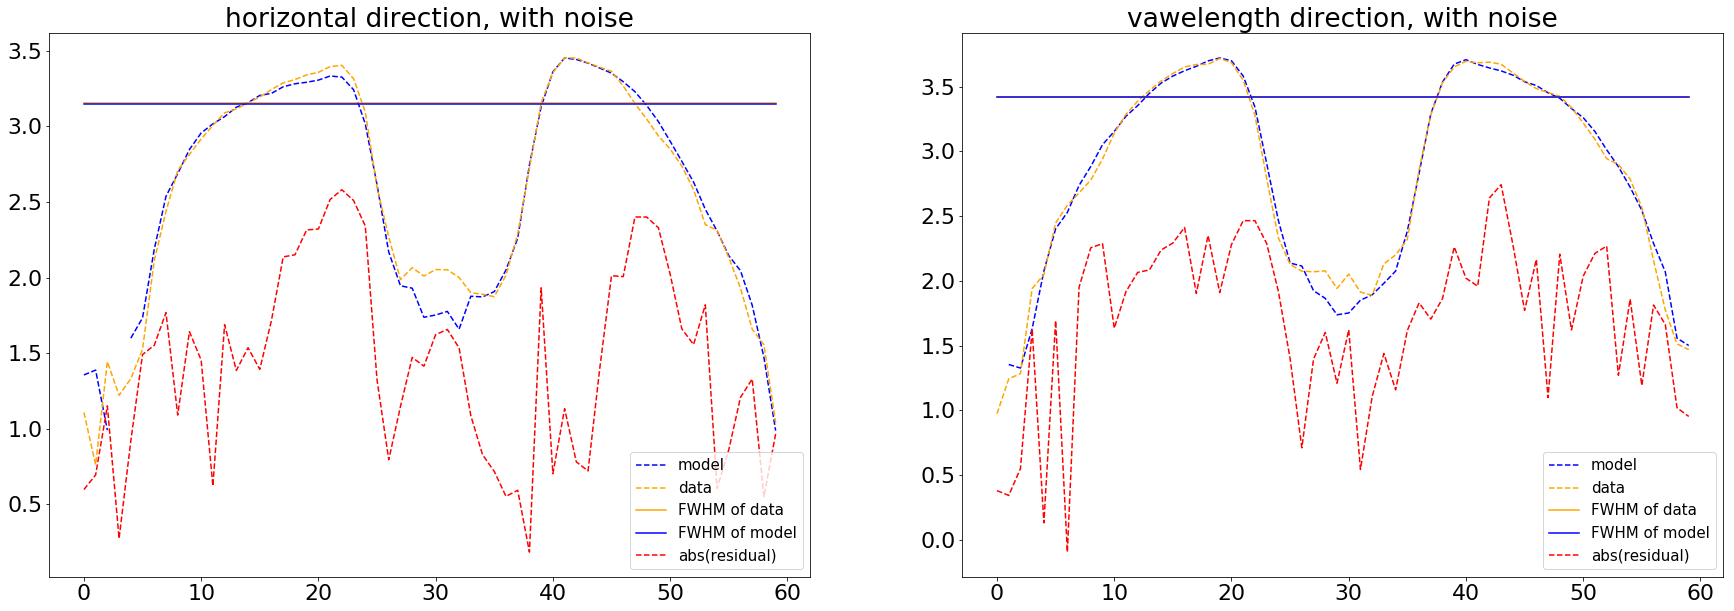

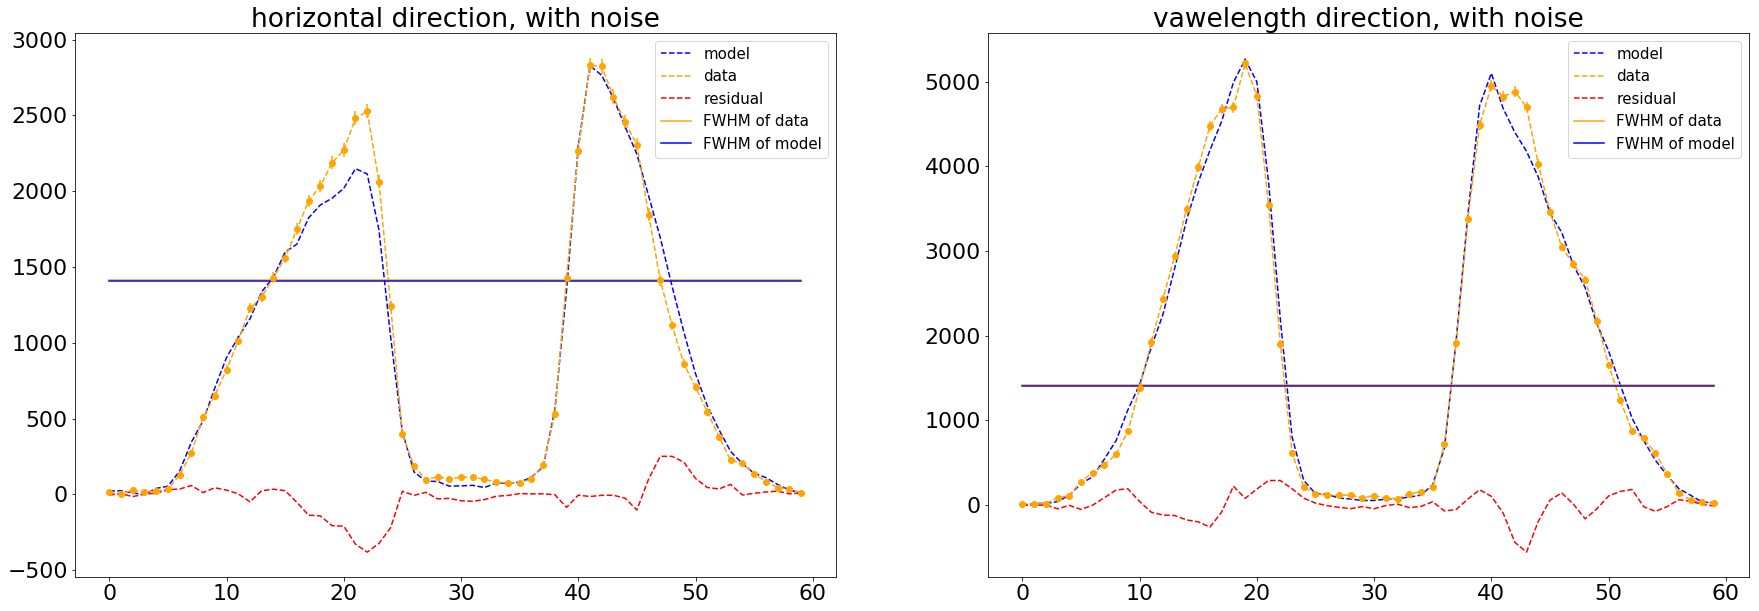

In [545]:
single_analysis.create_cut_plots()

## Preparation for focused data (total solution)

### creation of results_of_fit_many

In [40]:
def solution_at_0_and_plots(date,single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper):
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=3:
        solution_at_0=np.full(31,0)
        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:
            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr_err)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]

            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            interim_zero_solutions=[]
            if q in columns[:8]:
                # these variables are fit via linear fit, without values at focus
                # it is z4-z11
                # for loop below remove 2 point from the fit that create largerst deviations from median result in focus
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,lin_fit_1D(0,popt[0],popt[1])])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                #print(good_index)
                #print(index_arr_no0)
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            interim_zero_solutions=[]
            if q in columns[8:25]:
                # these variables are set at mean value (constant fit), without values at focus
                # these are variables that describe the pupil
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,popt[0]])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[25:]),np.array(['chi2','chi2max'])),axis=0):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######
            """
            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(single_number))

            plt.close()   
            """
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

In [41]:
single_number_for_single_pos_full=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 

columns_analysis=columns+['chi2','chi2max']

results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)
err_results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)

results_of_fit_many_single_defocus_pd=pd.DataFrame(results_of_fit_many_single_defocus)
err_results_of_fit_many_single_defocus_pd=pd.DataFrame(err_results_of_fit_many_single_defocus)

results_of_fit_many = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(100):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Nov03',single_number)
    solution_at_0=solution_at_0_and_plots('Nov03',single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many[label[i]]=results_of_fit_many[label[i]][np.abs(results_of_fit_many[label[i]]['z4'])>0]

NameError: name 'create_results_of_fit_single' is not defined

In [736]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov032018/' + 'results_of_fit_many.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many,f, protocol=pickle.HIGHEST_PROTOCOL)

In [737]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Nov03'
descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,7,8,9,10,16,17]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 9/9 [02:05<00:00, 13.91s/it]


<Figure size 864x720 with 0 Axes>

### 1D plots

In [738]:
res_y=[]
for i in [5,25,35,45,55,75,85,95]:
    res_y.append(4294-single_number_for_single_pos_full[i][4])
res_y=np.array(res_y)

In [739]:
res_x=[]
for i in [40,41,42,43,44,45,46,47,48,49]:
    res_x.append(single_number_for_single_pos_full[i][3])
res_x=np.array(res_x)

In [740]:
res_x[res_x>int(4096/2)]=res_x[res_x>int(4096/2)]+69

In [741]:
loc_w=[[2,3,4,5,6,7],[22,23,24,25,26,27],[32,33,34,35,36,37],[42,43,44,45,46,47],[52,53,54,55,56,57],[72,73,74,75,76,77],[82,83,84,85,86,87],[92,93,94,95,96,97]]
label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']
 
description='hscFrac'

for description in columns:

    res0=[]
    for w in [0,1,2,3,4,5,6,7]:
        res0.append(np.median(results_of_fit_many[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))

    res1=[]
    for w in [0,1,2,3,4,5,6,7]:
        res1.append(np.median(results_of_fit_many[label_short[1]].loc[loc_w[w]][description].dropna(how='all')))

    res2=[]
    for w in [0,1,2,3,4,5,6,7]:
        res2.append(np.median(results_of_fit_many[label_short[2]].loc[loc_w[w]][description].dropna(how='all')))

    res3=[]
    for w in [0,1,2,3,4,5,6,7]:
        res3.append(np.median(results_of_fit_many[label_short[3]].loc[loc_w[w]][description].dropna(how='all')))

    res4=[]
    for w in [0,1,2,3,4,5,6,7]:
        res4.append(np.median(results_of_fit_many[label_short[4]].loc[loc_w[w]][description].dropna(how='all')))

    res5=[]
    for w in [0,1,2,3,4,5,6,7]:
        res5.append(np.median(results_of_fit_many[label_short[5]].loc[loc_w[w]][description].dropna(how='all')))

    res6=[]
    for w in [0,1,2,3,4,5,6,7]:
        res6.append(np.median(results_of_fit_many[label_short[6]].loc[loc_w[w]][description].dropna(how='all')))

    res7=[]
    for w in [0,1,2,3,4,5,6,7]:
        res7.append(np.median(results_of_fit_many[label_short[7]].loc[loc_w[w]][description].dropna(how='all')))

    res8=[]
    for w in [0,1,2,3,4,5,6,7]:
        res8.append(np.median(results_of_fit_many[label_short[8]].loc[loc_w[w]][description].dropna(how='all')))

    res_defocused=np.array([res0,res1,res2,res6,res7,res8])
    #res_y_defocused=res_y[0,1,2,6,7,8]
    res_focused=np.array([res3,res4,res5])
        
    res_defocused_median=[]
    for i in range(res_defocused.shape[1]):
        x=res_defocused[:,i]
        x=x[~np.isnan(x)]
        res_defocused_median.append(np.median(x))
        
    popt, pcov = curve_fit(lin_fit_1DConstant, res_y, res_defocused_median)
        
    plt.figure(figsize=(30,12))
    plt.plot(res_y,res0,label='m4',color='red',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res1,label='m35',color='orange',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res2,label='m3',color='yellow',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res3,label='m05',color='brown',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res4,label='0',color='black',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res5,label='p05',color='violet',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res6,label='p3',color='magenta',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res7,label='p35',color='cyan',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res8,label='p3',color='blue',lw=3,marker='o',markersize=15)
    plt.plot(res_y,np.ones(len(res_y))*popt,label='def median',color='black',lw=3,marker='o',markersize=15,ls=':')
    plt.title('y: '+str(description))

    plt.legend()  

    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/1D/'

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER2+'y'+str(description))
    plt.close()

In [742]:
loc_w=[[0,20,30,40,50,60,70,80,90],[1,21,31,41,51,61,71,81,91],[2,22,32,42,52,62,72,82,92],[3,23,33,43,53,63,73,83,93],[4,24,34,44,54,64,74,84,94],[5,25,35,45,55,65,75,85,95],
       [6,26,36,46,56,66,76,86,96],[7,27,37,47,57,67,87,97],[8,28,38,48,58,68,78,88,98],[9,29,39,49,59,69,79,89,99]]
label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']

for description in columns:

    res0=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res0.append(np.mean(results_of_fit_many[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))

    res1=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res1.append(np.mean(results_of_fit_many[label_short[1]].loc[loc_w[w]][description].dropna(how='all')))

    res2=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res2.append(np.mean(results_of_fit_many[label_short[2]].loc[loc_w[w]][description].dropna(how='all')))

    res3=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res3.append(np.mean(results_of_fit_many[label_short[3]].loc[loc_w[w]][description].dropna(how='all')))

    res4=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res4.append(np.mean(results_of_fit_many[label_short[4]].loc[loc_w[w]][description].dropna(how='all')))

    res5=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res5.append(np.mean(results_of_fit_many[label_short[5]].loc[loc_w[w]][description].dropna(how='all')))

    res6=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res6.append(np.mean(results_of_fit_many[label_short[6]].loc[loc_w[w]][description].dropna(how='all')))

    res7=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res7.append(np.mean(results_of_fit_many[label_short[7]].loc[loc_w[w]][description].dropna(how='all')))

    res8=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res8.append(np.mean(results_of_fit_many[label_short[8]].loc[loc_w[w]][description].dropna(how='all')))

    plt.figure(figsize=(30,12))
    plt.plot(res_x,res0,label='m4',color='red',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res1,label='m35',color='orange',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res2,label='m3',color='yellow',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res3,label='m05',color='brown',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res4,label='0',color='black',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res5,label='p05',color='violet',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res6,label='p3',color='magenta',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res7,label='p35',color='cyan',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res8,label='p3',color='blue',lw=3,marker='o',markersize=15)
    plt.title('x: '+str(description))

    plt.legend()
    
    

    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/1D/'

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER2+'x'+str(description))
    plt.close()
    

### Creation of prediction for next fit and verification

In [744]:
from scipy.optimize import curve_fit

def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m15','m05','0d','0','p05','p15','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0d','0','p05']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [745]:
results_of_fit_many_interpolation = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}

In [746]:
i=0
all_x=single_number_for_single_pos_full[results_of_fit_many_interpolation[label[i]].index.astype(int)][:,3]
all_y=single_number_for_single_pos_full[results_of_fit_many_interpolation[label[i]].index.astype(int)][:,4]

In [766]:
all_x_center_break_added=all_x
all_x_center_break_added[all_x>int(4096/2)]=all_x[all_x>int(4096/2)]+69

all_x_in_respect_to_center=all_x_center_break_added-int((4096+69)/2)
all_y_in_respect_to_center=all_y-int(4176/2)

In [748]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']   

In [755]:
# parameters that vary slowly across the detector - describing wavefront and pupil (without illumination of the pupil)

single_parameter=[]
for j in ['z4','z5','z6','z7','z8','z9','z10','z11','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'det_vert','slitHolder_frac_dx','radiometricEffect','radiometricExponent','x_ilum','y_ilum']:
    for i in label_defocus:
        single_selection=results_of_fit_many[i][j]
        single_selection_x=all_x_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_y=all_y_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_z=np.full(len(single_selection),mm[label.index(i)])
        single_selection_values=single_selection.values
        single_selection_array=np.transpose(np.array([single_selection.index,single_selection_x,single_selection_y,single_selection_z,single_selection_values]))    
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]), ydata=single_parameter[:,4],p0=[0,0,0,0,0,0,0,0,0])
    print('Values for '+str(j)+': '+str(popt))
    print('Test value in center '+str(j)+': '+str(func([0,0,mm[label.index(i)]],*popt)))


    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=func([all_x_in_respect_to_center,all_y_in_respect_to_center,np.full(len(all_x),mm[label.index(i)])],*popt)

Values for z4: [-0.00006568  0.00000027 -0.00014818  0.00000011 -7.42665575 -0.90023945
  0.00000013  0.00001888  0.0000663 ]
Test value in center z4: -30.606862466794013
Values for z5: [ 0.00003211  0.00000007 -0.00008644  0.00000001  0.00877226 -0.27413031
  0.00000021  0.00019511 -0.00000581]
Test value in center z5: -0.2390412712608297
Values for z6: [-0.00000632  0.00000012 -0.00004336 -0.00000023  0.19673846 -0.12062302
 -0.00000002  0.00000134 -0.0000946 ]
Test value in center z6: 0.6663308349297364
Values for z7: [ 0.00003935 -0.00000003 -0.00011324  0.00000002 -0.05709727  0.42874637
  0.00000003 -0.00003427 -0.00000598]
Test value in center z7: 0.20035729795235677
Values for z8: [-0.00021191 -0.          0.00003451  0.00000002 -0.02469133  0.00596583
  0.00000004  0.0000362  -0.00001149]
Test value in center z8: -0.09279950953030111
Values for z9: [ 0.00004699  0.00000002 -0.00003841 -0.00000002  0.00376121 -0.15756271
  0.          0.00000794 -0.00000334]
Test value in cente

In [757]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['frd_sigma','frd_lorentz_factor','x_fiber','y_fiber','effective_radius_illumination']:
    dx=[]
    values=[]
    for i in label_defocus:
        if len(dx)==0:
            dx=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]
            values=results_of_fit_many[i][j]
        else:
            dx=np.hstack((dx,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
    fiber_r_res=[]
    for i in range(10):
        if len(values[dspot==i])>1:
            fiber_r_res.append(np.median(values[dspot==i]))
        else:
            fiber_r_res.append(1.8)


    dx=[]
    for i in label:
        dx=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]
        dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]

        values=[]
        for l in range(100):
            values.append(fiber_r_res[int(single_number_for_single_pos_full[l][1])])

    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=values

In [776]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        single_selection=results_of_fit_many[i][j]
        single_selection_x=all_x_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_y=all_y_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_z=np.full(len(single_selection),mm[label.index(i)])
        single_selection_values=single_selection.values
        single_selection_array=np.transpose(np.array([single_selection.index,single_selection_x,single_selection_y,single_selection_z,single_selection_values]))    
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]), single_parameter[:,4])
        #print(popt)


    #keep 'defocus parameter' at 0
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=func([all_x_in_respect_to_center,all_y_in_respect_to_center,np.full(len(all_x),0)],*popt)

In [759]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for values in focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dy=[]
    values=[]
    for i in ['0','0d']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]
            values=results_of_fit_many[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
grating_lines_res=[]
for i in range(10):
    if len(values[dspot==i])>1:
        grating_lines_res.append(np.median(values[dspot==i]))
    else:
        grating_lines_res.append(100000)
                                           
dy=[]
for i in label:
    dy=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,2]

    values=[]
    for l in range(100):
        values.append(grating_lines_res[int(single_number_for_single_pos_full[l][2])])
        
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation[i].at[:,j]=values


In [777]:
# parameters that vary as a function of fiber, sensitive in focus 
# we just select median value across all focused measurments?
inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dx=[]
    values=[]
    for i in label_focus:
        if len(dx)==0:
            dx=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]
            values=results_of_fit_many[i][j]
        else:
            dx=np.hstack((dx,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
    fiber_r_res=[]
    for i in range(10):
        if len(values[dspot==i])>1:
            fiber_r_res.append(np.median(values[dspot==i]))
        else:
            fiber_r_res.append(1.8)


    dx=[]
    for i in label:
        dx=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]
        dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]

        values=[]
        for l in range(100):
            values.append(fiber_r_res[int(single_number_for_single_pos_full[l][1])])

    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=values

In [778]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov032018/' + 'results_of_fit_many_interpolation.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation,f, protocol=pickle.HIGHEST_PROTOCOL)

#### verification 

In [779]:
from shutil import copy

In [780]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,5,7,8,9,10,12,16,17]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,8,9,12,13,14,15,16,17,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+min_dif
            min_colors=median_color-min_dif
            
        if np.in1d([i],[18,19])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+max_dif
            min_colors=median_color-max_dif            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Interpolation: '+str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        #copy(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]), IMAGES_FOLDER2)
        
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 11/11 [01:47<00:00,  9.74s/it]


<Figure size 864x720 with 0 Axes>

In [781]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,7,9,10,16,17,18]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many[label[j]][descriptions[i]])
        values_residuals=np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]])[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)]
        
        colors=values-values_residuals
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,8,9,12,13,14,15,16,17,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
            
        if np.in1d([i],[18,19])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+max_dif
            min_colors=median_color-max_dif   
            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title("Residuals: "+str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResidual/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResidual/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        copy(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i])+'.png', IMAGES_FOLDER2)
        
        
        #plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 9/9 [00:51<00:00,  5.71s/it]


<Figure size 864x720 with 0 Axes>

## Analysis of the focused data

In [1188]:
%load_ext autoreload
%autoreload 2

import Zernike_Module
from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters
Zernike_Module.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'0.13b'

In [1189]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']   

### Core Analysis (pandas dataframe creation)  (no defocus plots)

In [1191]:
def create_results_of_fit_single(date,single_number):
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                print(str(single_number)+' obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
            else:       
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' is NOT found or failed!')
            
            
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [1192]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    for var_number in range(len(columns)):
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            #print(step)
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except (IndexError,ValueError):
            print(columns[var_number]+': failed!')
            minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)

In [1193]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov032018/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)
    
single_number_for_single_pos_full\
=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

In [1194]:
columns_analysis=columns+['chi2','chi2max']

results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)
err_results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)

results_of_fit_many_single_defocus_pd=pd.DataFrame(results_of_fit_many_single_defocus)
err_results_of_fit_many_single_defocus_pd=pd.DataFrame(err_results_of_fit_many_single_defocus)

results_of_fit_many_focus = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}


In [1195]:
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(100):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Nov04',single_number)
    #solution_at_0=solution_at_0_and_plots('Sep27',single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_focus[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_focus[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:        
    results_of_fit_many_focus[label[i]]=results_of_fit_many_focus[label[i]][np.abs(results_of_fit_many_focus[label[i]]['z4'])>0]

0 8552 is NOT found or failed!
0 8555 is NOT found or failed!
0 8558 is NOT found or failed!
0 8561 is NOT found or failed!
0 8564 is NOT found or failed!
0 8567 is NOT found or failed!
0 8570 is NOT found or failed!
0 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_f

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
2 8606 is NOT found or failed!
2 8609 is NOT found or failed!
2 8612 is NOT found or failed!
2 8615 is NOT found or failed!
2 8618 is NOT found or failed!
2 8621 is NOT found or failed!
2 8624 is NOT found or failed!
2 8627 is NOT found or failed!
3 8552 is NOT found or failed!
3 8555 is NOT found or failed!
3 8558 is NOT found or failed!
3 8561 is NOT found or failed!
3 8564 is NOT found or failed!
3 8567 is NOT found or failed!
3 8570 is NOT found or failed!
3 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: fai

5 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
5 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: 

8 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
8 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: 

22 8552 is NOT found or failed!
22 8555 is NOT found or failed!
22 8558 is NOT found or failed!
22 8561 is NOT found or failed!
22 8564 is NOT found or failed!
22 8567 is NOT found or failed!
22 8570 is NOT found or failed!
22 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: fai

effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
24 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_

slitHolder_frac_dx: failed!
27 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
27 obs (Emcee3): 8603 is found!
z5: failed

frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
33 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitH

36 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
36 8606 is NOT found or failed!
36 8609 is NOT found or failed!
36 861

42 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
42 8606 is NOT found or failed!
42 8609 is NOT found or failed!
42 861

z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
46 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac:

dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
52 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: faile

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
55 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: faile

57 8606 is NOT found or failed!
57 8609 is NOT found or failed!
57 8612 is NOT found or failed!
57 8615 is NOT found or failed!
57 8618 is NOT found or failed!
57 8621 is NOT found or failed!
57 8624 is NOT found or failed!
57 8627 is NOT found or failed!
58 8552 is NOT found or failed!
58 8555 is NOT found or failed!
58 8558 is NOT found or failed!
58 8561 is NOT found or failed!
58 8564 is NOT found or failed!
58 8567 is NOT found or failed!
58 8570 is NOT found or failed!
58 8573 is NOT found or failed!
58 8600 is NOT found or failed!
58 8603 is NOT found or failed!
58 8606 is NOT found or failed!
58 8609 is NOT found or failed!
58 8612 is NOT found or failed!
58 8615 is NOT found or failed!
58 8618 is NOT found or failed!
58 8621 is NOT found or failed!
58 8624 is NOT found or failed!
58 8627 is NOT found or failed!
59 8552 is NOT found or failed!
59 8555 is NOT found or failed!
59 8558 is NOT found or failed!
59 8561 is NOT found or failed!
59 8564 is NOT found or failed!
59 8567 

radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
72 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: 

frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
74 8606 is NOT found or failed!
74 8609 is NOT found or failed!
74 8612 is NOT found or failed!
74 8615 is NOT found or failed!
74 8618 is NOT found or failed!
74 8621 is NOT found or failed!
74 8624 is NOT found or failed!
74 8627 is NOT found or failed!
75 8552 is NOT found or failed!
75 8555 is NOT found or failed!
75 8558 is NOT found or failed!
75 8561 is NOT found or failed!
75 8564 is NOT found or failed!
75 8567 is NOT found or failed!
75 8570 is NOT found or failed!
75 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: f

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
77 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: faile

83 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
83 8606 is NOT found or failed!
83 8609 is NOT found or failed!
83 861

frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
86 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitH

90 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
90 8606 is NOT found or failed!
90 8609 is NOT found or failed!
90 861

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
93 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: faile

x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
96 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effe

In [1198]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov032018/' + 'results_of_fit_many_focus.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_focus,f, protocol=pickle.HIGHEST_PROTOCOL)

### Plane plots

In [1210]:
list( descriptions[i] for i in [0, 25, 26, 27, 28,29,30] )

['z4',
 'grating_lines',
 'scattering_slope',
 'scattering_amplitude',
 'pixel_effect',
 'fiber_r',
 'flux']

In [1211]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Nov04'


descriptions=results_of_fit_many_focus[label[0]].columns
for j in tqdm([9,8,7,10]):
    for i in [0, 25, 26, 27, 28,29,30] :
        
        index_values=np.array(results_of_fit_many_focus[label[j]][descriptions[i]].index).astype(int)
        index_values=index_values[index_values!=83]
        
        x=single_number_for_single_pos_full[index_values][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[index_values][:,[4]].ravel()
        values=np.array(results_of_fit_many_focus[label[j]].loc[index_values][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
            

            
        #'chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        copy(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i])+'.png', IMAGES_FOLDER2)
        plt.clf()


  0%|          | 0/4 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/0/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/grating_lines/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/scattering_slope/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/scattering_amplitude/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/pixel_effect/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/fiber_r/



 25%|██▌       | 1/4 [00:01<00:04,  1.57s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/flux/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/0d/



 50%|█████     | 2/4 [00:03<00:03,  1.52s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Nov04/Plane/m05/



 75%|███████▌  | 3/4 [00:04<00:01,  1.54s/it]/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



ValueError: max() arg is an empty sequence

<Figure size 864x720 with 0 Axes>

## Look at result of the analysis at one single point - focus analysis

In [1264]:
obs='8603'
single_number='55'
image_index=int(single_number)
eps=5
#date='Sep19'
#date='Sep28'
date='Nov04'


obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

In [1265]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov032018/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)

allparameters_proposal=results_of_fit_many_interpolation[labelInput].loc[int(single_number)].values[:len(columns)]

In [1266]:
# this is proposal before the analysis of focused images
allparameters_proposal

dfz22 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

         z4        z5        z6        z7        z8        z9       z10  \
0 -0.920514 -0.280612 -0.130845  0.416954 -0.005011 -0.159377 -0.272438   

        z11  
0 -0.436678  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.672105   0.079069  0.026067  0.102143  0.065814     0.152244   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  
0           0.660836             0.987744  0.066345  0.165503  
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0  0.091303 -0.016013                       0.866866   0.093221   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.545723  1.020988           -0.001665   96674.693784   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.442426              0.011076       0.47079  1.885575  0.997524  


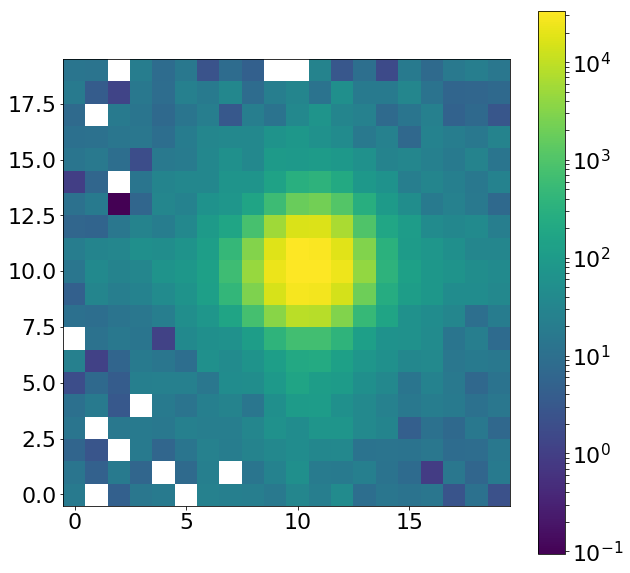

In [1267]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm(),origin='lower')
plt.colorbar()

In [1268]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 75, 31)
minimal likelihood is: 849.2865510424297
minimal chi2 reduced is: 4.209887259527463


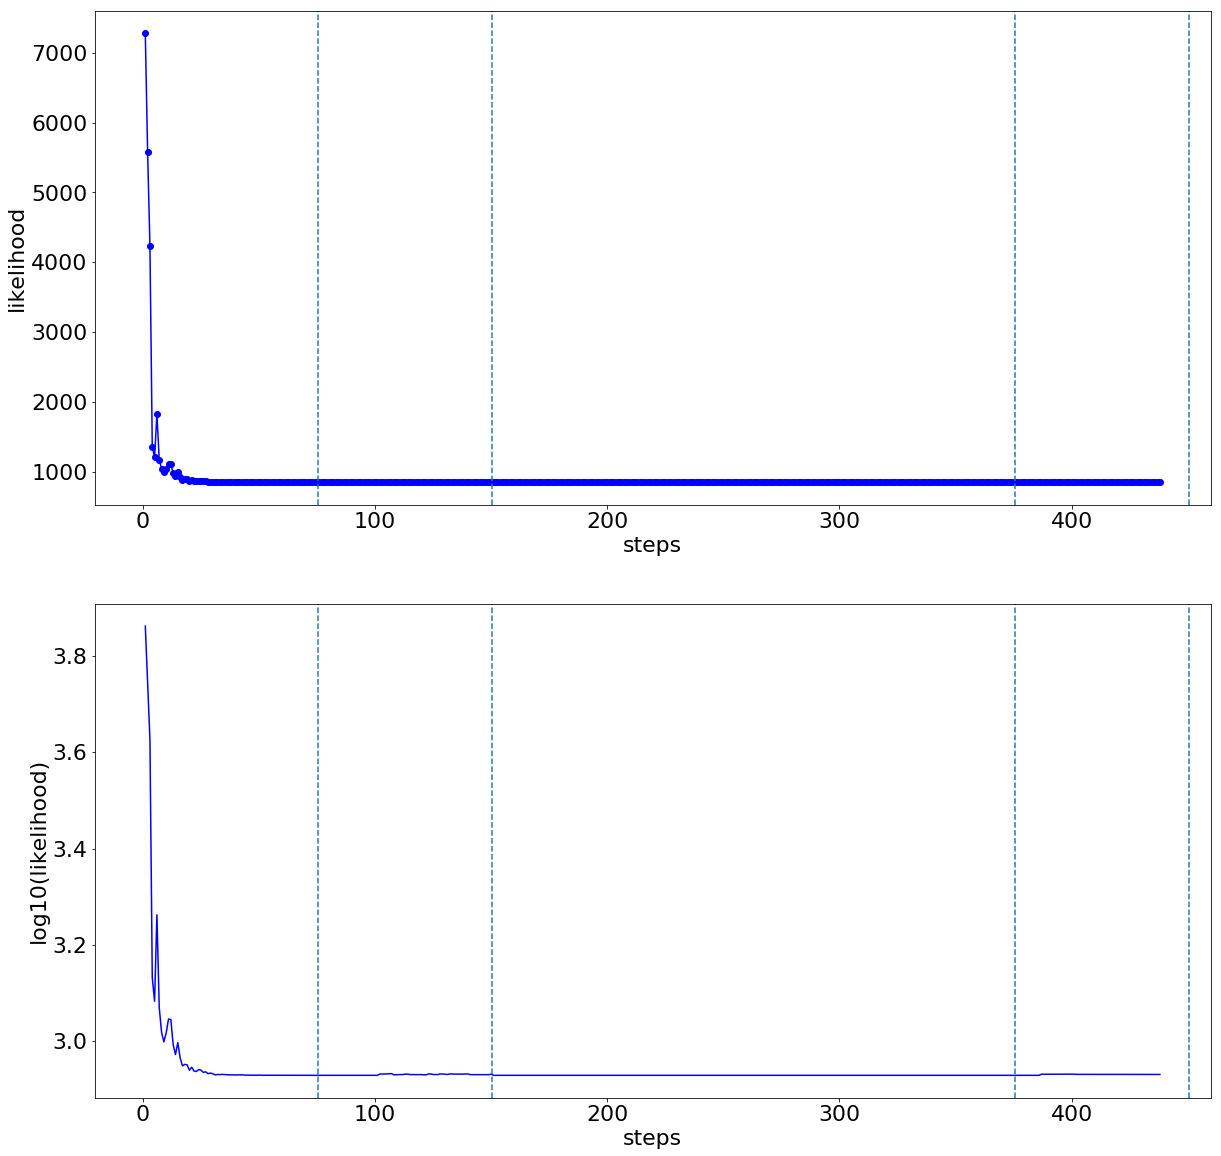

In [1269]:
size=75

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.axvline(size*6+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.axvline(6*size+0.5,ls='--')

In [1270]:
# this is proposal before the analysis of focused images
allparameters_proposal

dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

         z4        z5        z6        z7        z8        z9       z10  \
0 -0.574701 -0.282128 -0.113711  0.431942 -0.010751 -0.148701 -0.263263   

        z11  
0 -0.330429  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.671523   0.080653  0.016314  0.105192   0.06612     0.159678   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  
0           0.937676             1.063901  0.035997  0.029649  
   x_fiber  y_fiber  effective_radius_illumination  frd_sigma  \
0      0.0      0.0                       0.932925     0.0164   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0                 0.5  1.032829              0.0273   93522.753783   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.389995              0.003655      0.503334  1.890564  0.996891  


In [1271]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)

-849.2865510424443

In [1222]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

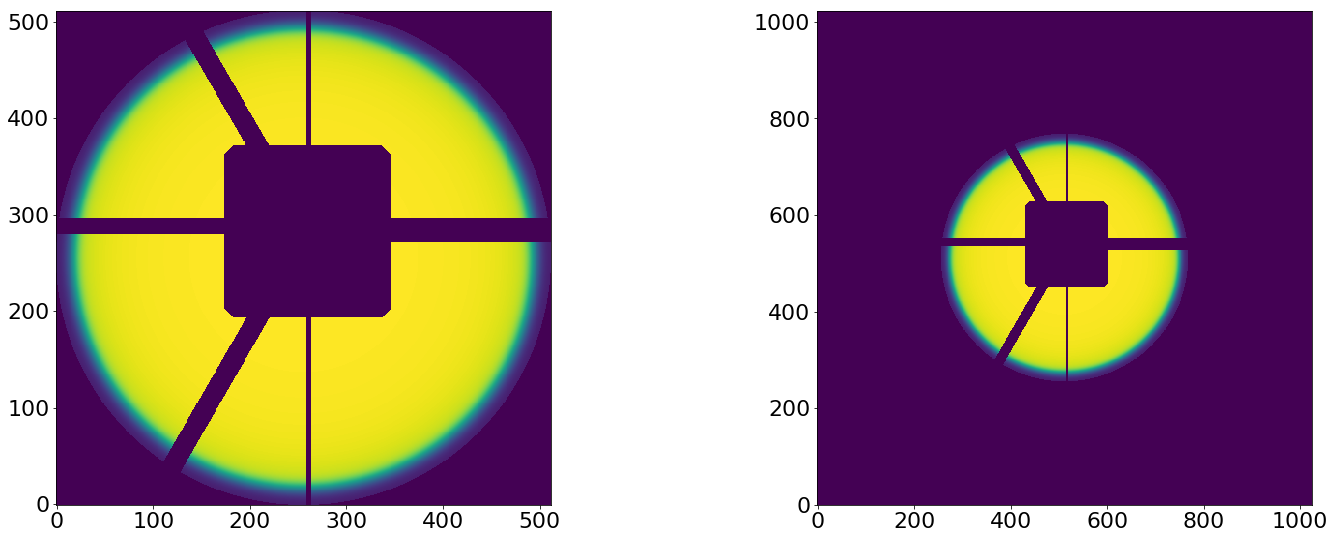

In [1223]:
plt.figure(figsize=(25,20))
plt.subplot(221)
plt.imshow(pupililluminated,origin='lower')
plt.subplot(222)
plt.imshow(ilum,origin='lower')

chi**2 reduced is: 4.209887263346586
Abs of residual divided by total flux is: 0.04045967974590758
Abs of residual divided by largest value of a flux in the image is: 0.061137906505770466


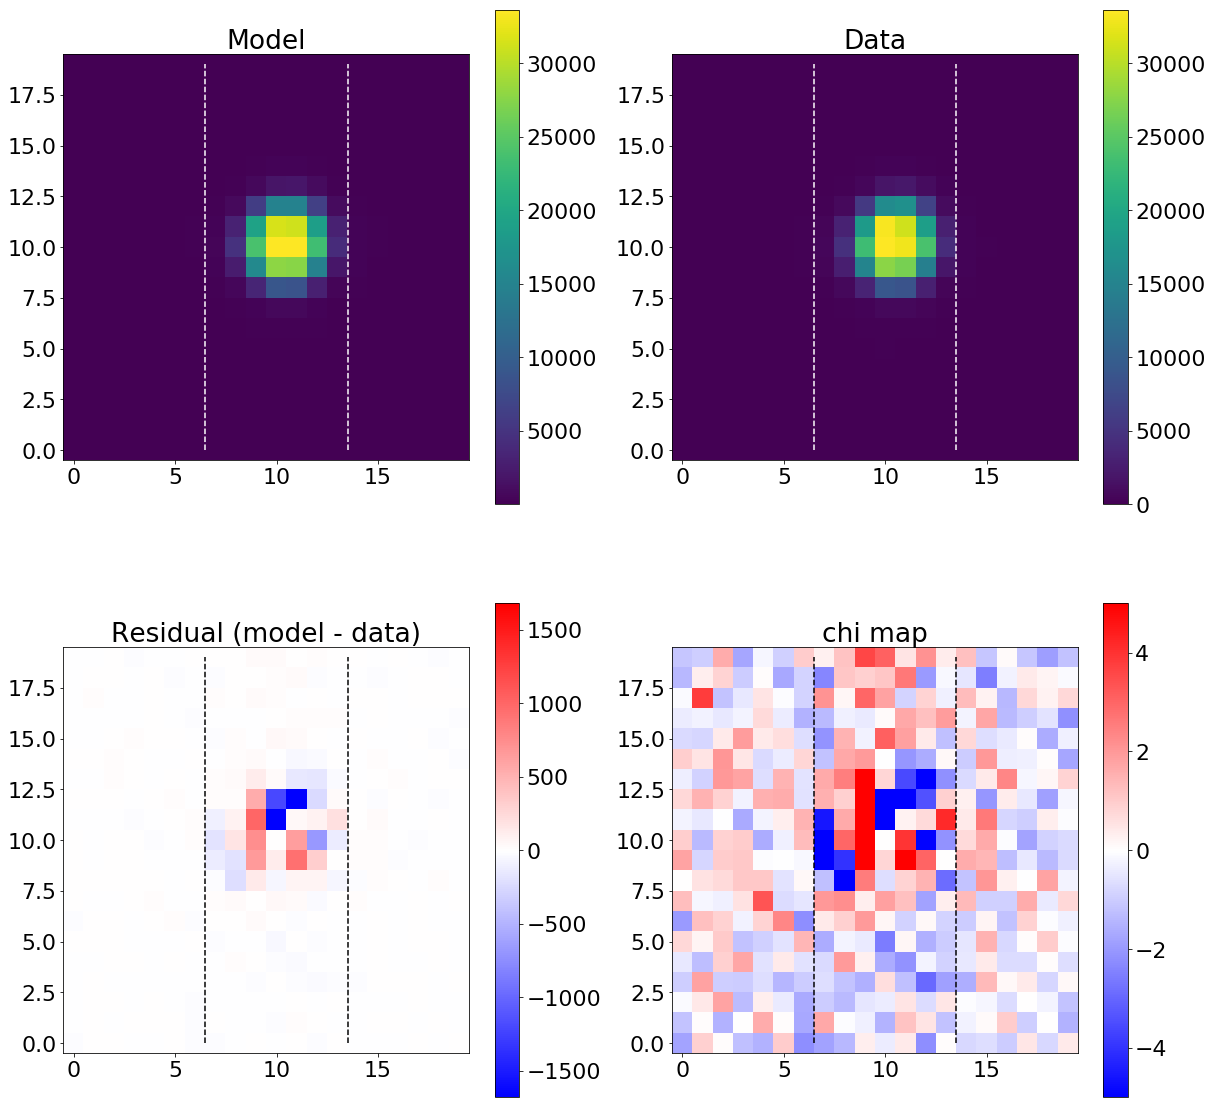

In [1224]:
single_analysis.create_basic_comparison_plot()

4.209887263346586
chi**2 reduced is: 4.209887263346586
Abs of residual divided by total flux is: 0.04045967974590758
Abs of residual divided by largest value of a flux in the image is: 0.061137906505770466


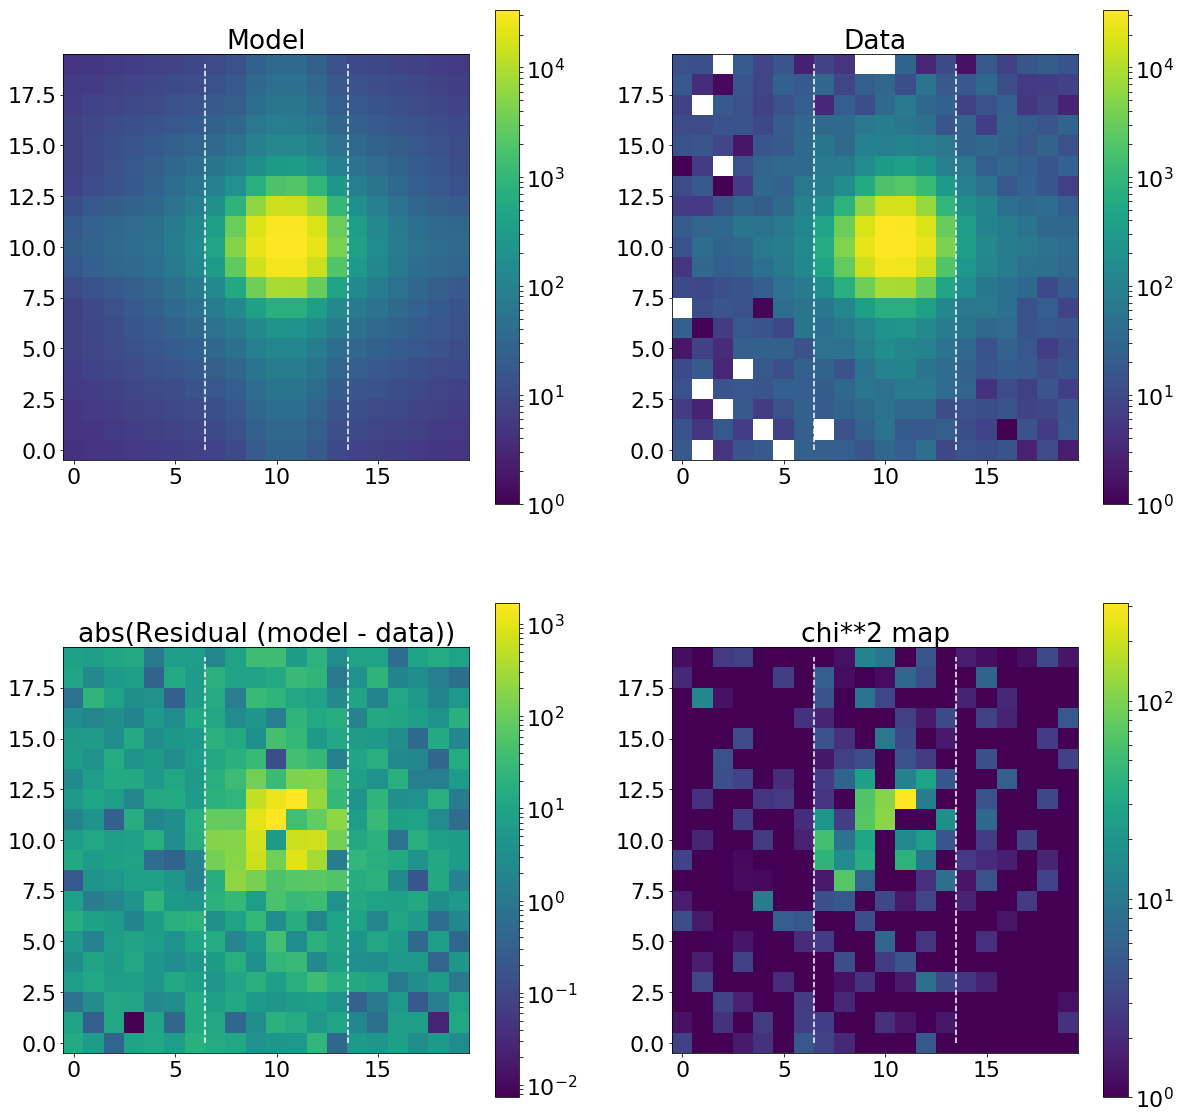

In [1225]:
single_analysis.create_basic_comparison_plot_log()

4.209887263346586


0.04045967974590758

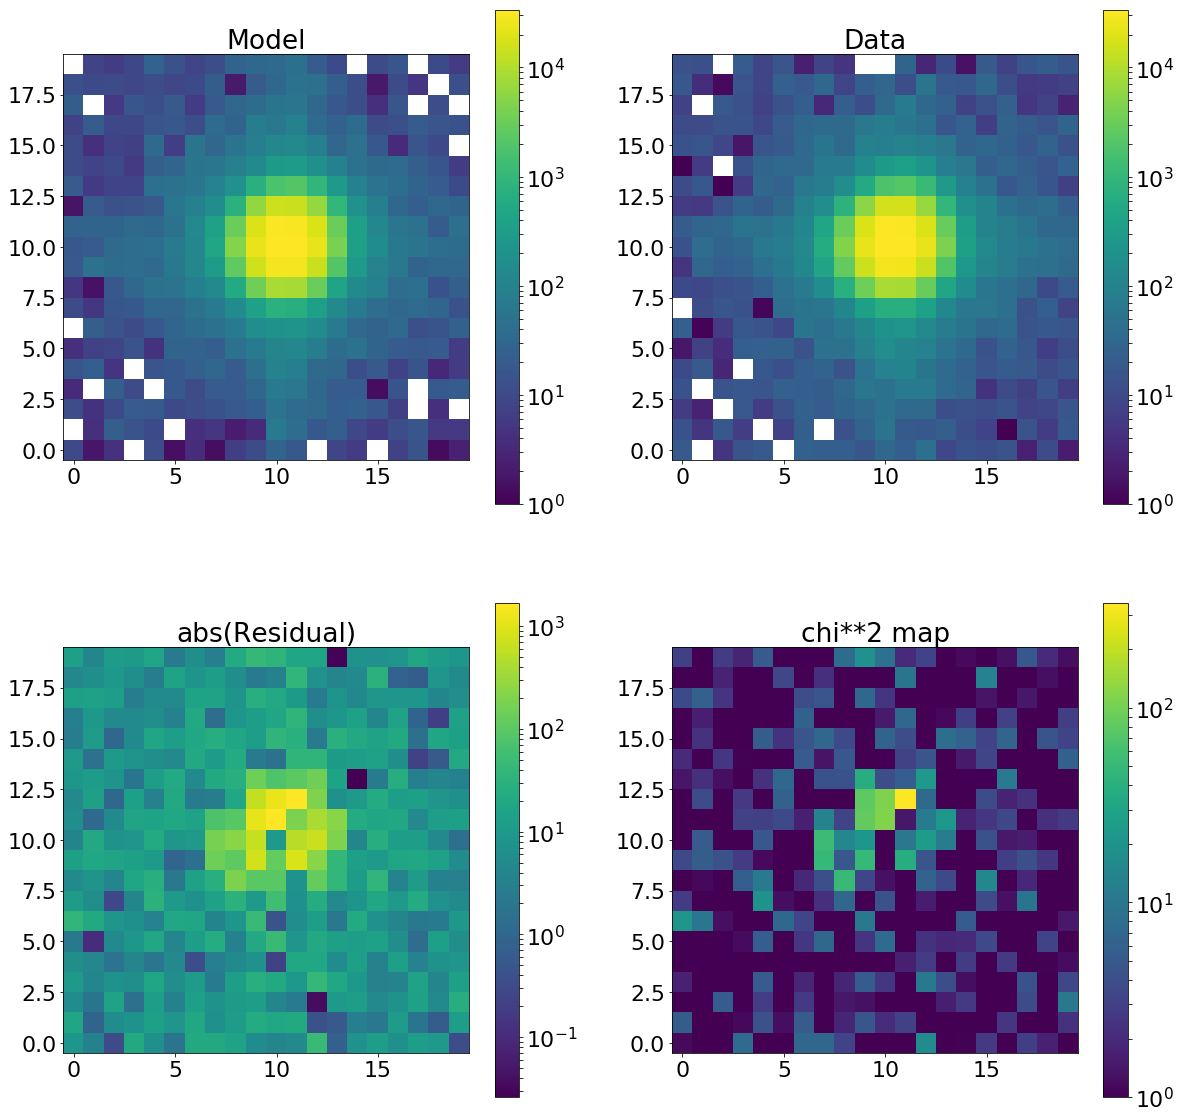

In [1226]:
artifical_noise=single_analysis.create_artificial_noise()


plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

8.858268875152982
13.955094227399332


Text(0.5,1,'chi map downsampled 4x')

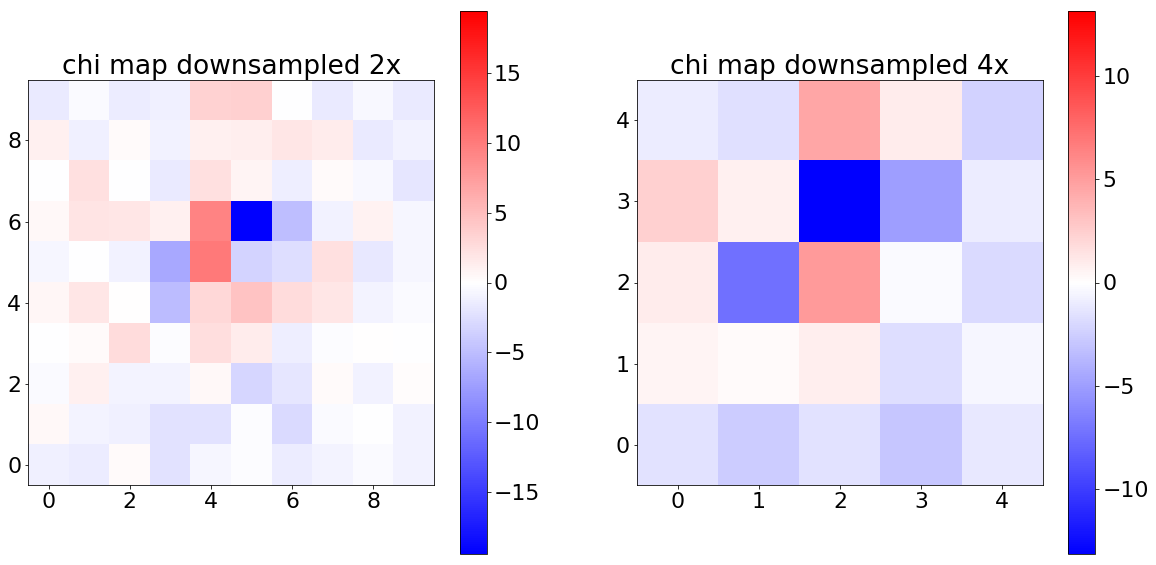

In [1227]:
sci_image_2=downsample_manual_function(sci_image,int(sci_image.shape[0]/2))
sci_image_4=downsample_manual_function(sci_image,int(sci_image.shape[0]/4))

res_iapetus_2=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/2))
res_iapetus_4=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/4))

var_image_2=downsample_manual_function(var_image,int(var_image.shape[0]/2))
var_image_4=downsample_manual_function(var_image,int(var_image.shape[0]/4))

chi_downsample_2=(res_iapetus_2-sci_image_2)/np.sqrt(var_image_2)
chi_downsample_4=(res_iapetus_4-sci_image_4)/np.sqrt(var_image_4)

print(np.mean(chi_downsample_2**2))
print(np.mean(chi_downsample_4**2))


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_2,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_2)),vmax=np.max(np.abs(chi_downsample_2)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_4,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_4)),vmax=np.max(np.abs(chi_downsample_4)))
plt.colorbar()
plt.title('chi map downsampled 4x')

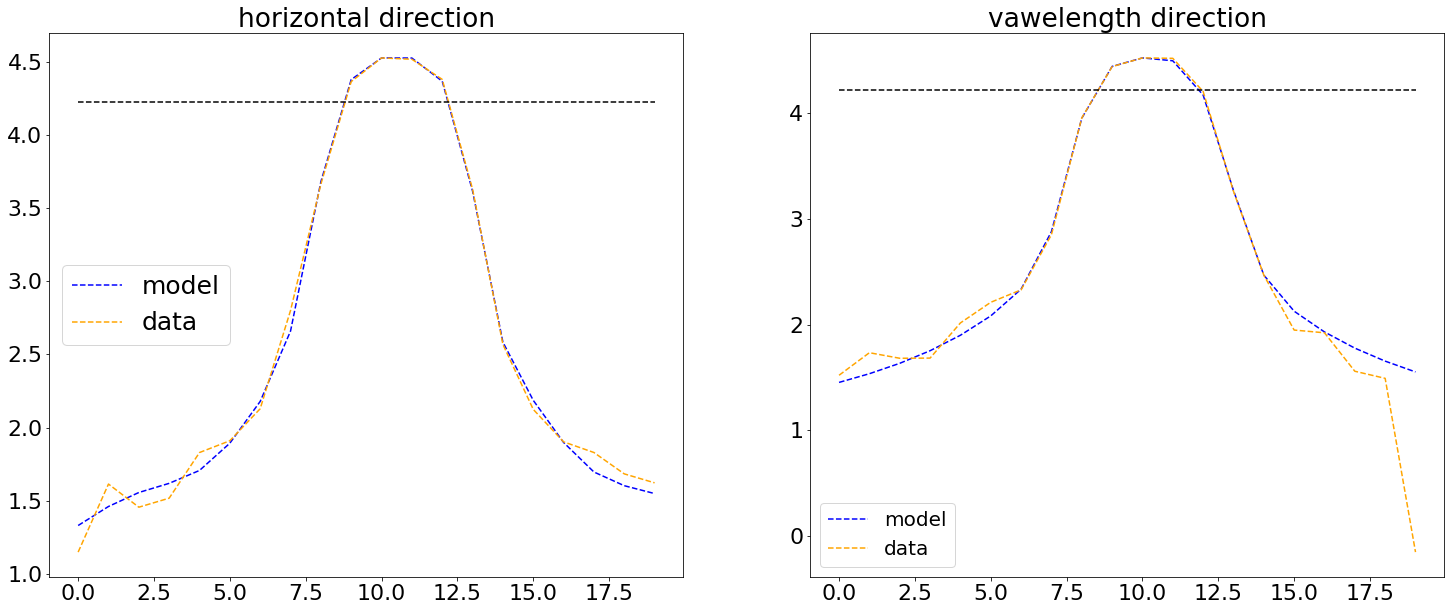

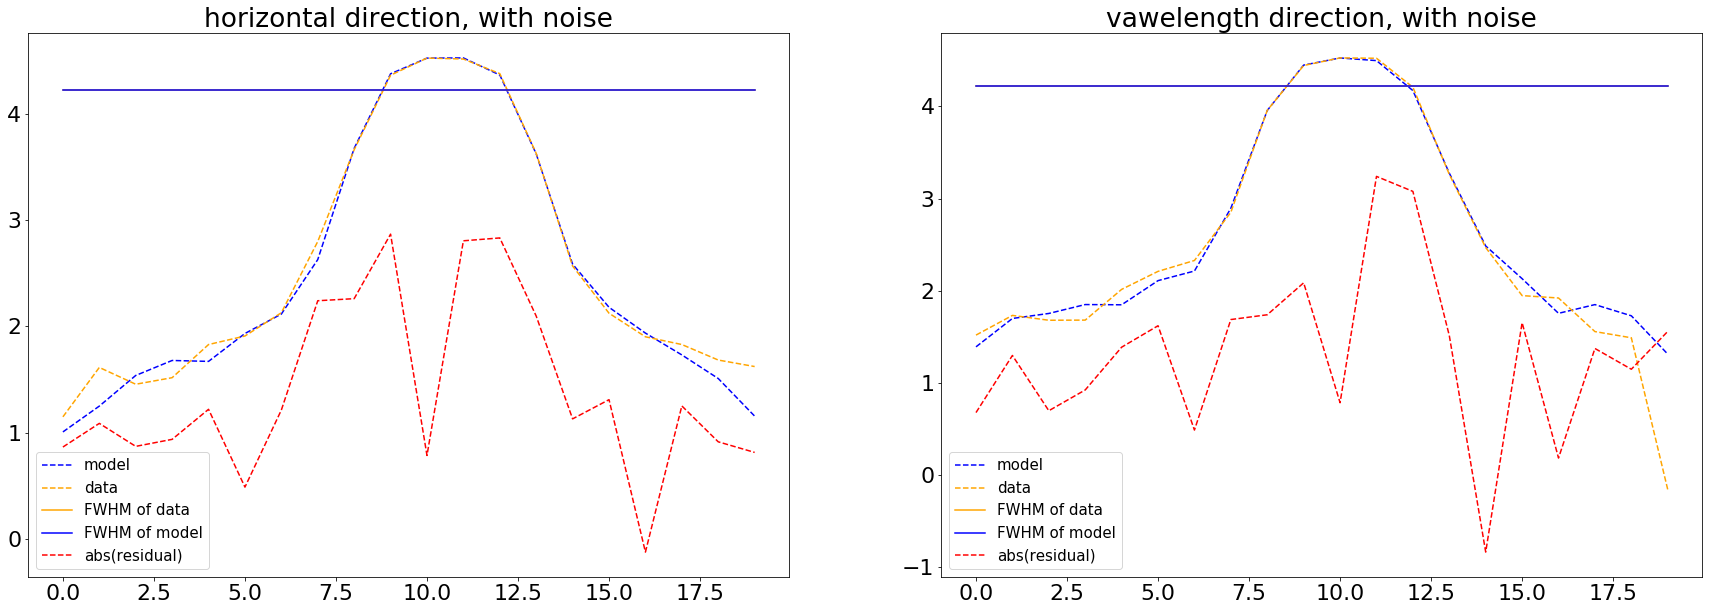

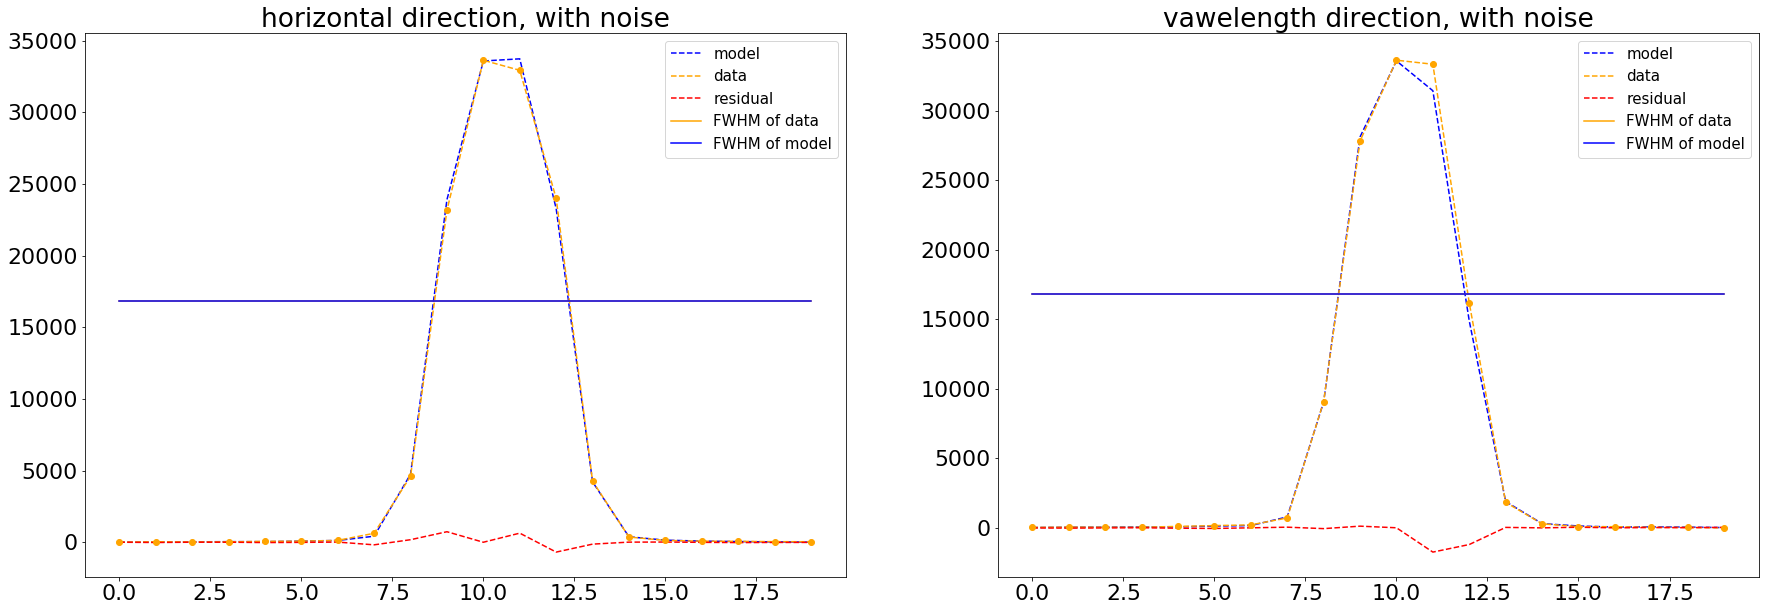

In [1228]:
single_analysis.create_cut_plots()

## Total solution

In [1229]:
from scipy.optimize import curve_fit
import pickle
date='Nov03'

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+'2018/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)
    
def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0','p05']
label_focusd=['m05','0','0d','p05']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [1230]:
results_of_fit_many_interpolation_with_focus = {'m4': results_of_fit_many_interpolation['m4'].copy(), 
                       'm35' :results_of_fit_many_interpolation['m35'].copy(),
                       'm3' :  results_of_fit_many_interpolation['m3'].copy(),
                       'm25' : results_of_fit_many_interpolation['m25'].copy(),
                       'm2' :results_of_fit_many_interpolation['m2'].copy(),
                       'm15' : results_of_fit_many_interpolation['m15'].copy(),
                       'm1' :results_of_fit_many_interpolation['m1'].copy(),
                       'm05' : results_of_fit_many_interpolation['m05'].copy(),
                       '0d' : results_of_fit_many_interpolation['0d'].copy(),
                       '0' :  results_of_fit_many_interpolation['0'].copy(),
                       'p05' :results_of_fit_many_interpolation['p05'].copy(),
                       'p1' : results_of_fit_many_interpolation['p1'].copy(),
                       'p15': results_of_fit_many_interpolation['p15'].copy(),
                       'p2' : results_of_fit_many_interpolation['p2'].copy(),
                       'p25' :results_of_fit_many_interpolation['p25'].copy(),
                       'p3' : results_of_fit_many_interpolation['p3'].copy(),
                       'p35' : results_of_fit_many_interpolation['p35'].copy(),
                        'p4' :results_of_fit_many_interpolation['p4'].copy(),
                      '0p' :results_of_fit_many_interpolation['0p'].copy()}

In [1231]:
i=0
all_x=single_number_for_single_pos_full[results_of_fit_many_interpolation_with_focus[label[i]].index.astype(int)][:,3]
all_y=single_number_for_single_pos_full[results_of_fit_many_interpolation_with_focus[label[i]].index.astype(int)][:,4]

all_x[all_x>int(4096/2)]=all_x[all_x>int(4096/2)]+69

all_x_in_respect_to_center=all_x-int((4096+69)/2)
all_y_in_respect_to_center=all_y-int(4176/2)

In [1232]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']   

In [1234]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['z4','scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        single_selection=results_of_fit_many_focus[i][j]
        

        # removing 83
        single_selection_index=single_selection.index
        single_selection_index=single_selection_index[single_selection_index!=83]
        single_selection=single_selection.loc[single_selection_index]
        
        single_selection_x=all_x_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_y=all_y_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_z=np.full(len(single_selection),mm[label.index(i)])
        single_selection_values=single_selection.values
        single_selection_array=np.transpose(np.array([single_selection.index,single_selection_x,single_selection_y,single_selection_z,single_selection_values]))    
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]), single_parameter[:,4])
        #print(popt)


    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_with_focus[i].at[:,j]=func([all_x_in_respect_to_center,all_y_in_respect_to_center,np.full(len(all_x),mm[label.index(i)])],*popt)

In [1236]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all focused measurments?
inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dx=[]
    values=[]
    for i in label_focus:
        if len(dx)==0:
            dx=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,3]
            dspot=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,2]
            dfiber=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,1]

            values=results_of_fit_many_focus[i][j]
        else:
            dx=np.hstack((dx,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,3]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,2]))
            dfiber=np.hstack((dfiber,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many_focus[i][j]))           
            
            
    fiber_r_res=[]
    for i in range(10):
        if len(values[dspot==i])>1:
            fiber_r_res.append(np.median(values[dfiber==i]))
        else:
            fiber_r_res.append(1.8)


    dx=[]
    for i in label:
        dx=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]
        dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]

        values=[]
        for l in range(100):
            values.append(fiber_r_res[int(single_number_for_single_pos_full[l][1])])

    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_with_focus[i].at[:,j]=values

#### graiting

In [1239]:
import astropy
from astropy.io import fits
from scipy.interpolate import interp1d

detector_map = fits.open('/Users/nevencaplar/Documents/PFS/DetectorMap/pfsDetectorMap-005833-r1.fits')

single_number_for_single_pos_full_y_reversed=single_number_for_single_pos_full
single_number_for_single_pos_full_y_reversed[:,4]=4176-single_number_for_single_pos_full_y_reversed[:,4]

In [1240]:
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dy=[]
    values=[]
    for i in ['0','0d']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full_y_reversed[results_of_fit_many_focus[i][j].index.astype(int)][:,4]
            dspot=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,2]
            dfiber=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,1]
            values=results_of_fit_many_focus[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full_y_reversed[results_of_fit_many_focus[i][j].index.astype(int)][:,4]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,2]))
            dfiber=np.hstack((dfiber,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many_focus[i][j]))           
            
            
grating_lines_res=[]
for i in range(10):
    if len(values[dspot==i])>1:
        grating_lines_res.append(np.median(values[dspot==i]))
    else:
        grating_lines_res.append(100000)

In [1241]:
fiberID=np.round(np.array([6,67,194,257,315,337,393,455,582,644])*600/650).astype(int)

dy_changed_to_dwavelength=[]
for j in range(len(dy)):
    i=fiberID[int(dfiber[j])]
    single_fiber_y_data=detector_map[3].data[i][0]
    single_fiber_x_data=detector_map[3].data[i][1]
    single_fiber_wavelength_data=detector_map[3].data[i][3]
    f = interp1d(single_fiber_y_data, single_fiber_wavelength_data,fill_value="extrapolate")
    dy_changed_to_dwavelength.append(f(dy[j]))
    
dy_changed_to_dwavelength=np.array(dy_changed_to_dwavelength)

In [1242]:
dy_changed_to_dwavelength_sorted=dy_changed_to_dwavelength[np.argsort(dy_changed_to_dwavelength)]
values_sorted=values[np.argsort(dy_changed_to_dwavelength)]
position_of_break=np.argwhere(np.diff(dy_changed_to_dwavelength_sorted)>10).ravel()
position_of_break=np.insert(position_of_break,0,0)
position_of_break=np.insert(position_of_break,len(position_of_break),len(dy_changed_to_dwavelength_sorted))
position_of_break

array([  0,  17,  29,  41,  53,  63,  73,  85, 106])

In [1243]:
res_wavelength=[]
res_values=[]
for i in range(len(position_of_break)-1):
    res_wavelength.append(dy_changed_to_dwavelength_sorted[position_of_break[i]+1:position_of_break[i+1]])
    res_values.append(values_sorted[position_of_break[i]+1:position_of_break[i+1]])

In [1244]:
res_res_wavelength=[]
res_res_values=[]
for i in res_wavelength:
    res_res_wavelength.append(np.median(i))
    
for i in res_values:
    res_res_values.append(np.median(i))

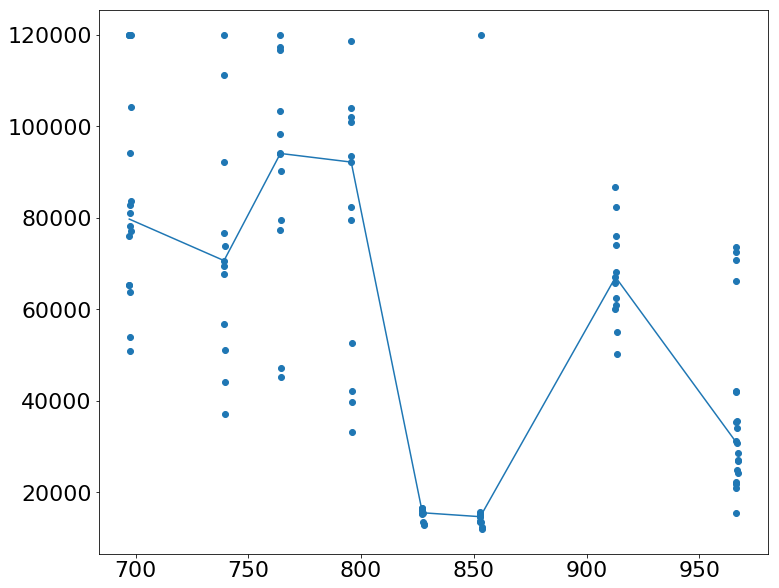

In [1245]:
grating_lines_fit=interp1d(res_res_wavelength,res_res_values,fill_value="extrapolate")
plt.scatter(dy_changed_to_dwavelength,values)
plt.plot(dy_changed_to_dwavelength_sorted,grating_lines_fit(dy_changed_to_dwavelength_sorted))

In [1246]:
dy=[]
for i in label:
    dy=single_number_for_single_pos_full_y_reversed[results_of_fit_many_interpolation[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,2]
    dfiber=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]     
    
    values=[]
    for l in range(100):
        z=fiberID[int(dfiber[l])]
        single_fiber_y_data=detector_map[3].data[z][0]
        single_fiber_x_data=detector_map[3].data[z][1]
        single_fiber_wavelength_data=detector_map[3].data[z][3]
        f = interp1d(single_fiber_y_data, single_fiber_wavelength_data,fill_value="extrapolate")
        f(grating_lines_fit(dy[l]))
        
        values.append(f(grating_lines_fit(dy[l])))
   
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation_with_focus[i].at[:,j]=values

In [1247]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for 2 value in focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dy=[]
    values=[]
    for i in ['0','0d']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,4]
            dspot=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,2]
            dfiber=single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,1]
            values=results_of_fit_many_focus[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,4]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,2]))
            dfiber=np.hstack((dfiber,single_number_for_single_pos_full[results_of_fit_many_focus[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many_focus[i][j]))           
            
"""        
grating_lines_res=[]
for i in range(10):
    if len(values[dspot==i])>1:
        grating_lines_res.append(np.median(values[dspot==i]))
    else:
        grating_lines_res.append(100000)
                                           
dy=[]
for i in label:
    dy=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,2]

    values=[]
    for l in range(100):
        values.append(grating_lines_res[int(single_number_for_single_pos_full[l][2])])
        
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation_with_focus[i].at[:,j]=values
"""  
# have to run "next level grating with splines "
# this creates function grating_lines_fit which gives number of grating lines as a function of wavelegth
# for each spot you have to find which wavelength does it correspond

dy=[]
for i in label:
    dy=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,2]
    dfiber=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]     
    
    values=[]
    for l in range(100):
        z=fiberID[int(dfiber[l])]
        single_fiber_y_data=detector_map[3].data[z][0]
        single_fiber_x_data=detector_map[3].data[z][1]
        single_fiber_wavelength_data=detector_map[3].data[z][3]
        f = interp1d(single_fiber_y_data, single_fiber_wavelength_data,fill_value="extrapolate")
        grating_lines_fit(f(dy[l]))
        
        values.append( grating_lines_fit(f(dy[l])))
   
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation_with_focus[i].at[:,j]=values    

### verification 

In [1255]:
descriptions[27]

'scattering_amplitude'

In [1256]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Nov04'
descriptions=results_of_fit_many_interpolation_with_focus[label[0]].columns
for j in tqdm([7,8,9,10]):
    for i in range(0,len(columns)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+min_dif
            min_colors=median_color-min_dif
            if i==27:
                min_colors=0
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Focus Interpolation: '+str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 4/4 [00:37<00:00,  9.34s/it]


<Figure size 864x720 with 0 Axes>

## spline solution?

In [13]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Nov032018/' + 'results_of_fit_many_focus.pkl', 'rb') as f:
    results_of_fit_many_focus=pickle.load(f)



In [ ]:
# create oversampled images

In [64]:
labelInput='0'
list_of_optPsf_cut_grating_convolved=[]
for single_number in [5,25,35,45,55,75,85,95]:

    obs=8603
    allparameters_proposal=results_of_fit_many_focus[labelInput].loc[int(single_number)].values[:len(columns)]
    minchain=allparameters_proposal


    if obs=='8600':
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
    else:       
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

    if obs=='8600':
        model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
    else:
        model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   

    model(minchain)

    optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
    list_of_optPsf_cut_grating_convolved.append(optPsf_cut_grating_convolved/np.sum(optPsf_cut_grating_convolved))
    
array_of_optPsf_cut_grating_convolved=np.array(list_of_optPsf_cut_grating_convolved)

In [65]:
# I probably want to do that with wavelength and not position on detector
res=[]
for i in [5,25,35,45,55,75,85,95]:
    res.append(single_number_for_single_pos_full[single_number_for_single_pos_full[:,0]==i])
    
res=np.array(res)
res=res[:,0]
res

array([[   5.,    5.,    0., 2091.,  213.],
       [  25.,    5.,    2., 2090.,  853.],
       [  35.,    5.,    3., 2091., 1559.],
       [  45.,    5.,    4., 2091., 1858.],
       [  55.,    5.,    5., 2091., 2224.],
       [  75.,    5.,    7., 2091., 2586.],
       [  85.,    5.,    8., 2092., 2873.],
       [  95.,    5.,    9., 2092., 3351.]])

In [92]:
from scipy.interpolate import interp1d
x=res[:,4]
array_with_spline_functions=[]
for i in tqdm(range(len(array_of_optPsf_cut_grating_convolved[0]))):
    for j in range(len(array_of_optPsf_cut_grating_convolved[0])):
        y=array_of_optPsf_cut_grating_convolved[:,i,j]
        f2 = interp1d(x, y, kind='cubic',fill_value="extrapolate")
        array_with_spline_functions.append([i,j,f2])
        
array_with_spline_functions=np.array(array_with_spline_functions)
array_with_spline_functions=array_with_spline_functions.reshape(252,252,3)

100%|██████████| 252/252 [00:17<00:00, 14.67it/s]


In [117]:
optical_psf=[]
for i in range(252):
    for j in range(252):
        optical_psf.append(array_with_spline_functions[i,j,2](2228))
        
optical_psf=np.array(optical_psf).reshape(252,252)

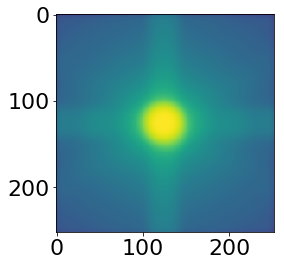

In [118]:
plt.imshow(optical_psf,norm=LogNorm())

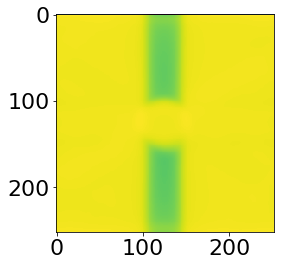

In [119]:
plt.imshow((optical_psf-array_of_optPsf_cut_grating_convolved[4])/optical_psf)

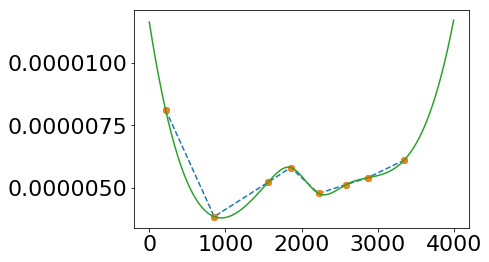

In [81]:
plt.plot(res[:,4],array_of_optPsf_cut_grating_convolved[:,100,100],'o',ls='--')
plt.plot(x, f2(x), 'o')
plt.plot(range(4000), f2(range(4000)) )

In [82]:
f2

In [63]:
np.sum(optPsf_cut_grating_convolved)

3227425914.3349137

# Finding more spots for analysis

In [129]:
from astropy.io import fits
pfsFiberFlat=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/TESTNOV08/CALIB/FLAT/pfsFiberFlat-2017-12-13-008288-r1.fits')
pfsFiberTrace=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/TESTNOV08/CALIB/FIBERTRACE/pfsFiberTrace-2017-12-20-008957-r1.fits')

In [138]:
pfsFiberFlat[3].shape

(4176, 4096)

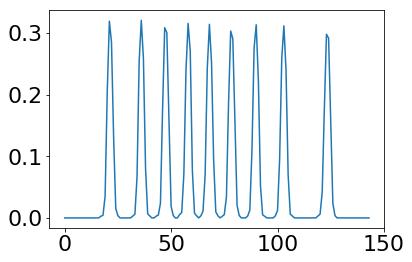

In [153]:
plt.plot(pfsFiberTrace[1].data[2024])

In [178]:
9*16.5

148.5

In [160]:
from astropy.io import fits
pfsFiberFlat=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/TESTNOV08WrongImageFlat/CALIB/FLAT/pfsFiberFlat-2017-12-20-008957-r1.fits')
pfsFiberTrace=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/TESTNOV08WrongImageFlat/CALIB/FIBERTRACE/pfsFiberTrace-2017-12-20-008957-r1.fits')

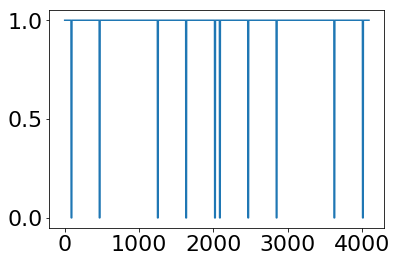

In [176]:
plt.plot(pfsFiberFlat[3].data[2000])

# corellations 

In [11]:
from scipy.stats.stats import pearsonr   
from tqdm import tqdm

In [1119]:
label[17]

'p4'

In [1118]:
obs_possibilites[17]

8627

In [12]:
obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4']

l=9
multi_cor=[]
for single_number in results_of_fit_many[label[l]].index.values.astype(int):
    print(single_number)
    obs=str(obs_possibilites[l])
    #single_number='23'
    image_index=int(single_number)
    eps=5
    date='Nov03'
    try:
        single_analysis=Zernike_Analysis(date,obs,single_number,eps)
        minchain,like_min=single_analysis.create_likelihood()
        chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()


        if obs=='8600':
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
        else:       
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

        chain0_Emcee3_ravel=chain0_Emcee3.reshape(chain0_Emcee3.shape[0]*chain0_Emcee3.shape[1],chain0_Emcee3.shape[2])
        chi2_Emcee3_ravel=(-(np.array(likechain0_Emcee3)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2).ravel()
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel)
        chi2_Emcee3_ravel_reduced=chi2_Emcee3_ravel/min_chi2_Emcee3_ravel_sort
        chain0_Emcee3_ravel_good=chain0_Emcee3_ravel[chi2_Emcee3_ravel_reduced<2]

        sorted_idx = np.lexsort(chain0_Emcee3_ravel_good.T)
        sorted_data =  chain0_Emcee3_ravel_good[sorted_idx,:]
        # Get unique row mask
        row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
        # Get unique rows
        chain0_Emcee3_ravel_good = sorted_data[row_mask]

        res=[]
        for i in tqdm(range(np.shape(chain0_Emcee3_ravel_good)[1])):
              for j in range(np.shape(chain0_Emcee3_ravel_good)[1]):
                res.append(pearsonr(chain0_Emcee3_ravel_good[:,i],chain0_Emcee3_ravel_good[:,j])[0])

        res=np.array(res)
        pearsonr_full_chain=res.reshape(np.shape(chain0_Emcee3_reshaped)[1],np.shape(chain0_Emcee3_reshaped)[1])
        multi_cor.append(pearsonr_full_chain)
    except FileNotFoundError:
        pass
multi_cor=np.array(multi_cor)

NameError: name 'results_of_fit_many' is not defined

In [1129]:
multi_cor_averaged=[]
for i in range(31):
    for j in range(31):
        x=multi_cor[:,i,j]
        x = x[np.logical_not(np.isnan(x))]
        multi_cor_averaged.append(np.median(x))
        
multi_cor_averaged=np.array(multi_cor_averaged).reshape(31,31)

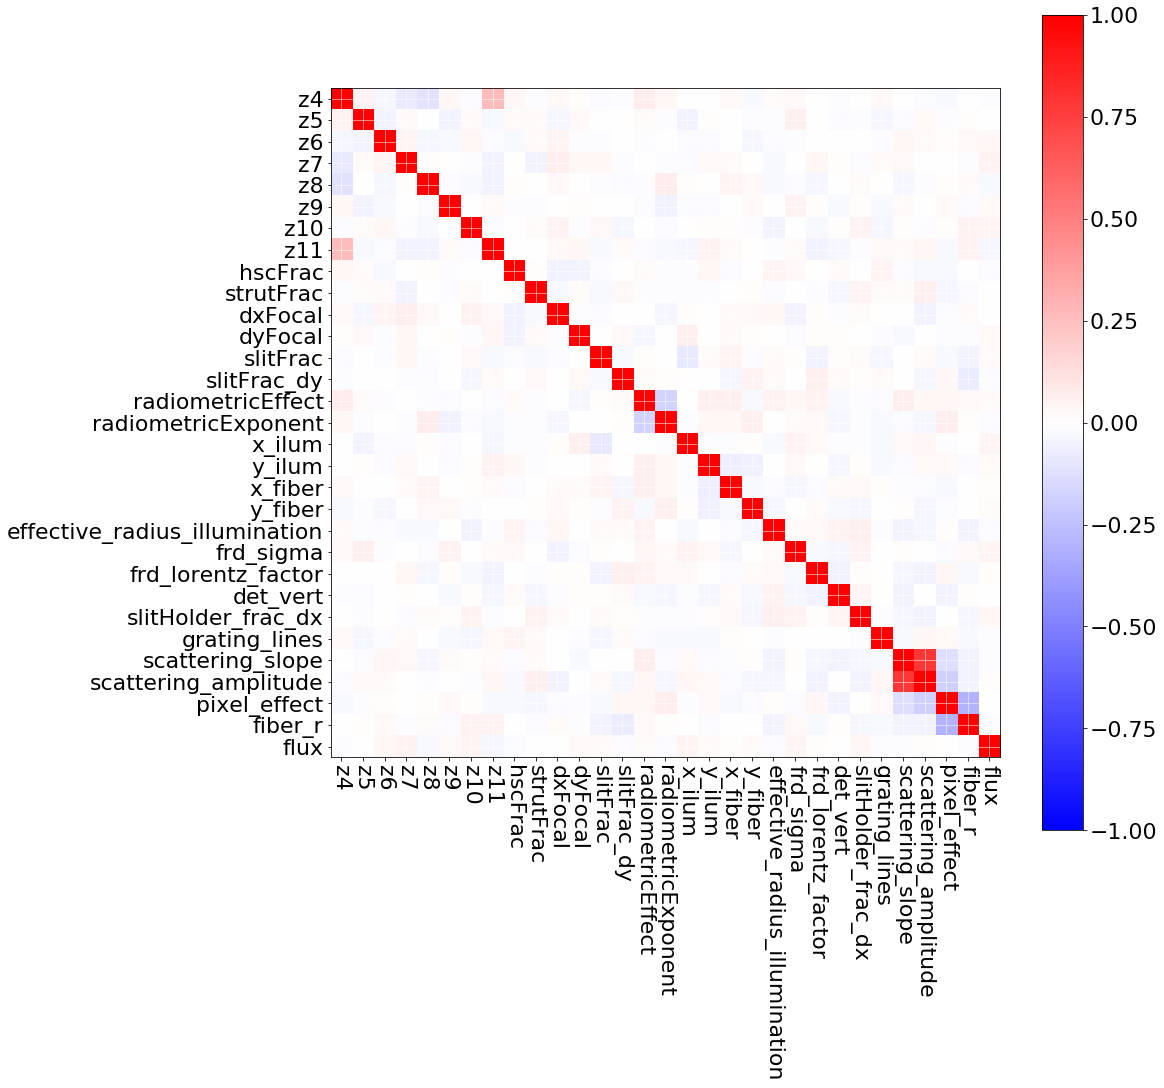

In [1130]:
plt.figure(figsize=(15,15))
plt.imshow(multi_cor_averaged,vmin=-1,cmap='bwr')
ax = plt.gca();
ax.set_yticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_yticklabels(columns,rotation=0);
ax.set_xticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_xticklabels(columns,rotation=-90);
ax.grid(color='w', linestyle='-', linewidth=0.5)
plt.colorbar()

In [1126]:
multi_cor_averaged_chopped=multi_cor_averaged
multi_cor_averaged_chopped[np.abs(multi_cor_averaged)<0.3]=0

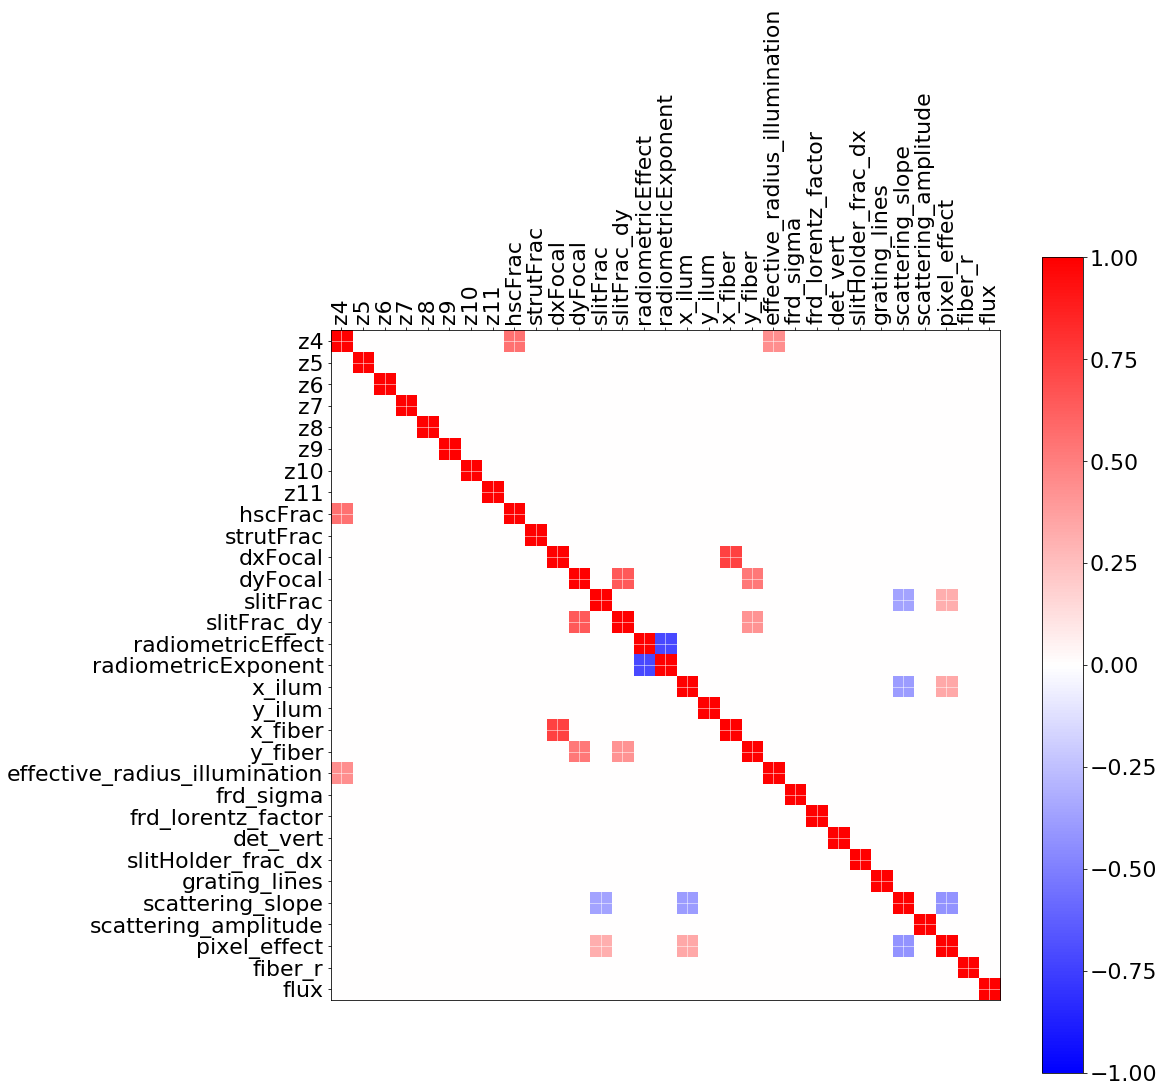

In [1127]:
plt.figure(figsize=(15,15))
plt.imshow(multi_cor_averaged_chopped,vmin=-1,vmax=1,cmap='bwr')
ax = plt.gca();
ax.set_yticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_yticklabels(columns,rotation=0);
ax.set_xticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_xticklabels(columns,rotation=90);
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

ax.grid(color='w', linestyle='-', linewidth=0.5)
plt.colorbar()

In [862]:
var_number=0

likechain0_Emcee3_ravel=np.ravel(likechain0)

# connect chain and lnchain
chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

# simplest standard deviation
std_chain=np.std(chain0_Emcee3_ravel_sort)

#best solution
mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

# step size
step=std_chain/10

# create result 3*std in each direction

res=[]
for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
    selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
    if len(selected_chi2_Emcee3_ravel_sort>10):   
        res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

res=np.array(res)

#print(columns[var_number]+' min : '+str(mean_chain))
#print(columns[var_number]+' std : '+str(std_chain))

# find low limit and high limit
res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]


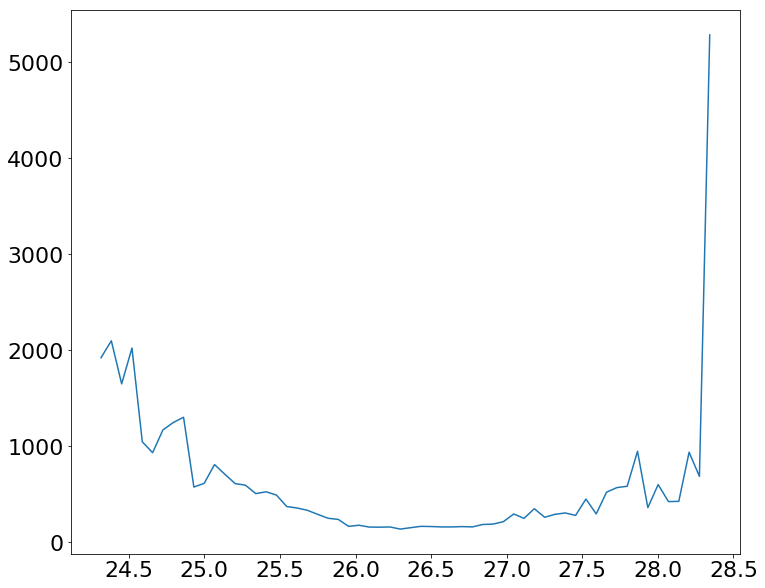

In [864]:
plt.plot(res[:,0],res[:,1])

In [980]:
columns[13]

'slitFrac_dy'

In [981]:
columns[5]

'z9'

In [982]:
obs='8558'
single_number='23'
image_index=int(single_number)
eps=5
date='Nov03'

single_analysis=Zernike_Analysis(date,obs,single_number,eps)
minchain,like_min=single_analysis.create_likelihood()
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()


obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')


chi2_Emcee3_ravel=-(np.array(likechain.ravel())*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2


new_array=np.zeros((248*60,3))
new_array[:,0]=chain0[:,:,13].ravel()
new_array[:,1]=chain0[:,:,5].ravel()
new_array[:,2]=chi2_Emcee3_ravel.ravel()

sorted_idx = np.lexsort(new_array.T)
sorted_data =  new_array[sorted_idx,:]

# Get unique row mask
row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))

# Get unique rows
new_array = sorted_data[row_mask]


std_chain0=np.std(new_array[:,0])
std_chain1=np.std(new_array[:,1])
step0=std_chain0/3
step1=std_chain1/3
mean_chain0=np.mean(new_array[:,0])
mean_chain1=np.mean(new_array[:,1])

res=[]
for i in np.arange(mean_chain0-10*step0,mean_chain0+10*step0,step0):
    selected_new_array=new_array[(np.array(new_array[:,0]<i+step0)&np.array(new_array[:,0]>i))]
    selected_new_array_sorted=selected_new_array[selected_new_array[:,1].argsort()]
    for j in range(int(selected_new_array[selected_new_array[:,1].argsort()].shape[0]/5)):
        selected_new_array_sorted_subset=selected_new_array_sorted[j*5:(j+1)*5]
        res.append(np.mean(selected_new_array_sorted_subset,axis=0))
        
res=np.array(res)

res[:,0]=(res[:,0]-mean_chain0)/std_chain0
res[:,1]=(res[:,1]-mean_chain1)/std_chain1
res[:,2]=(res[:,2]-np.min(res[:,2]))/np.min(res[:,2])

(number of walkers, number of steps, number of parameters): (248, 60, 31)
minimal likelihood is: 21021.57011531341
minimal chi2 reduced is: 26.265969190004654


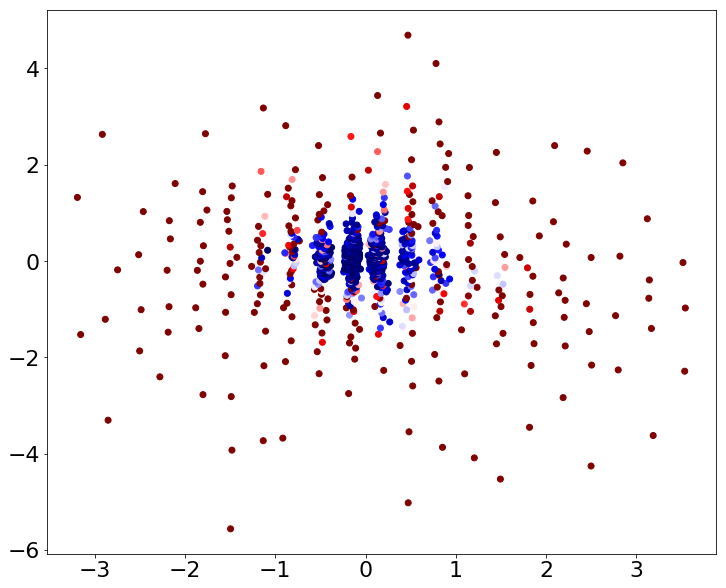

In [984]:
colors=res[:,2]
plt.scatter(res[:,0],res[:,1],c=colors, cmap='seismic', alpha=1,vmin=0, vmax=5)

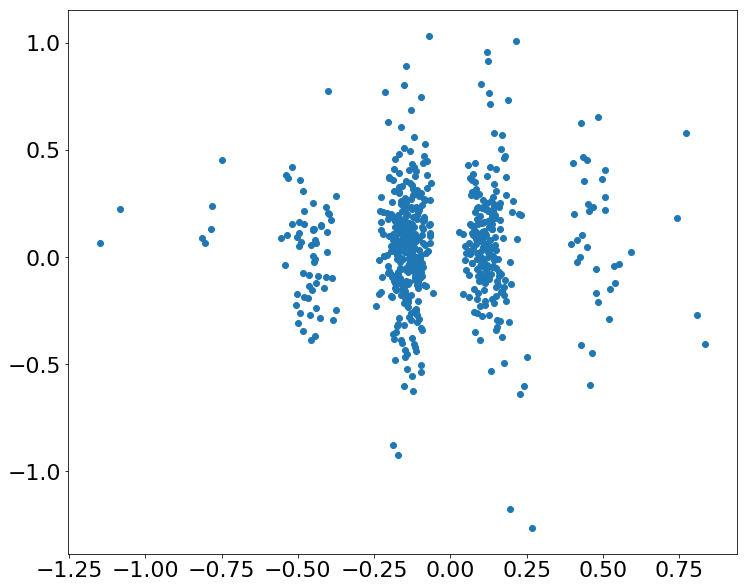

In [986]:
plt.scatter(res[res[:,2]<1][:,0],res[res[:,2]<1][:,1])

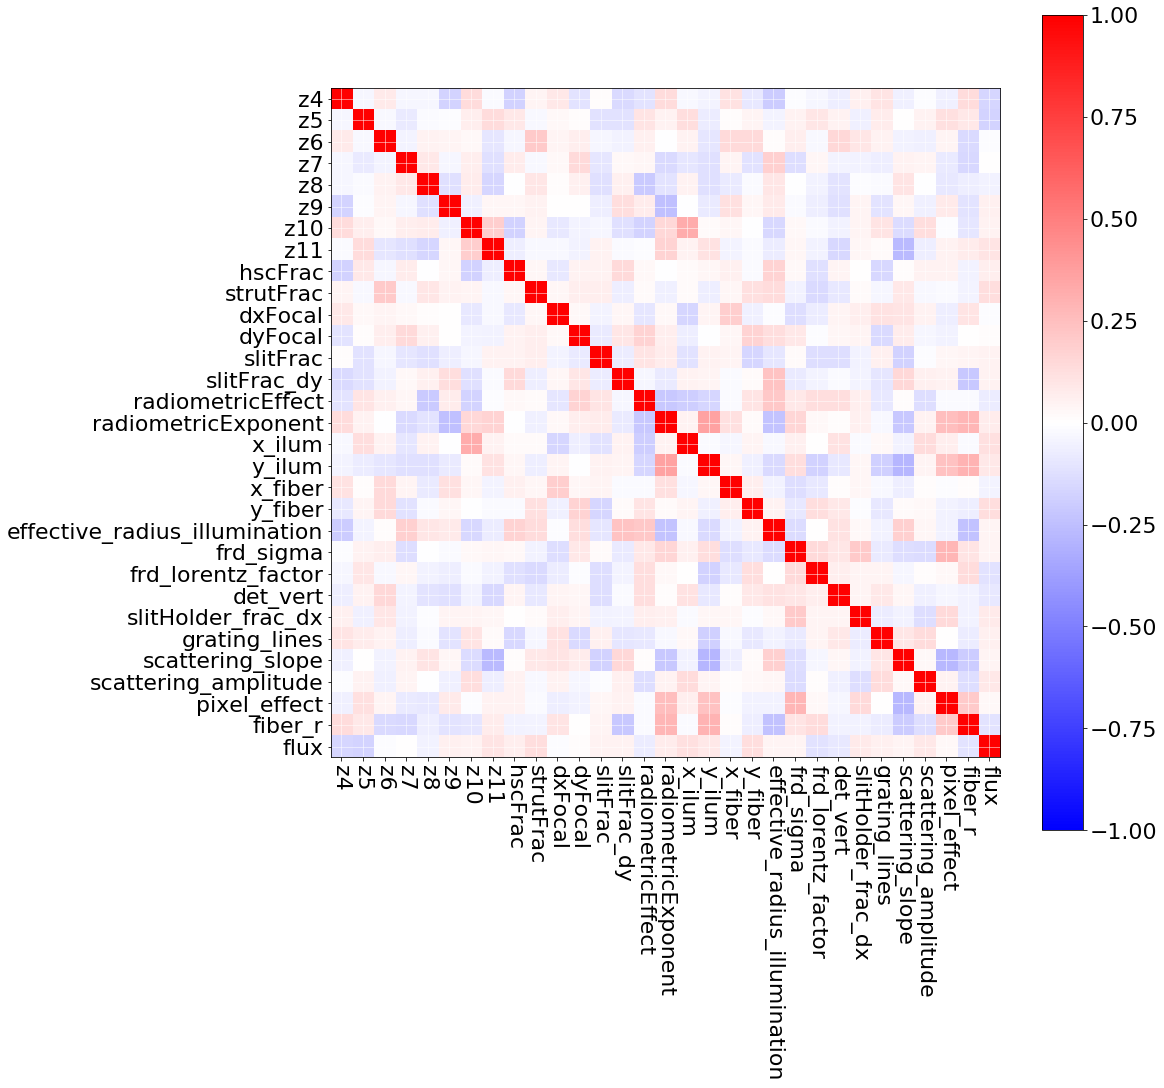

In [940]:
plt.figure(figsize=(15,15))
plt.imshow(pearsonr_full_chain,vmin=-1,cmap='bwr')
ax = plt.gca();
ax.set_yticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_yticklabels(columns,rotation=0);
ax.set_xticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_xticklabels(columns,rotation=-90);
ax.grid(color='w', linestyle='-', linewidth=0.5)
plt.colorbar()

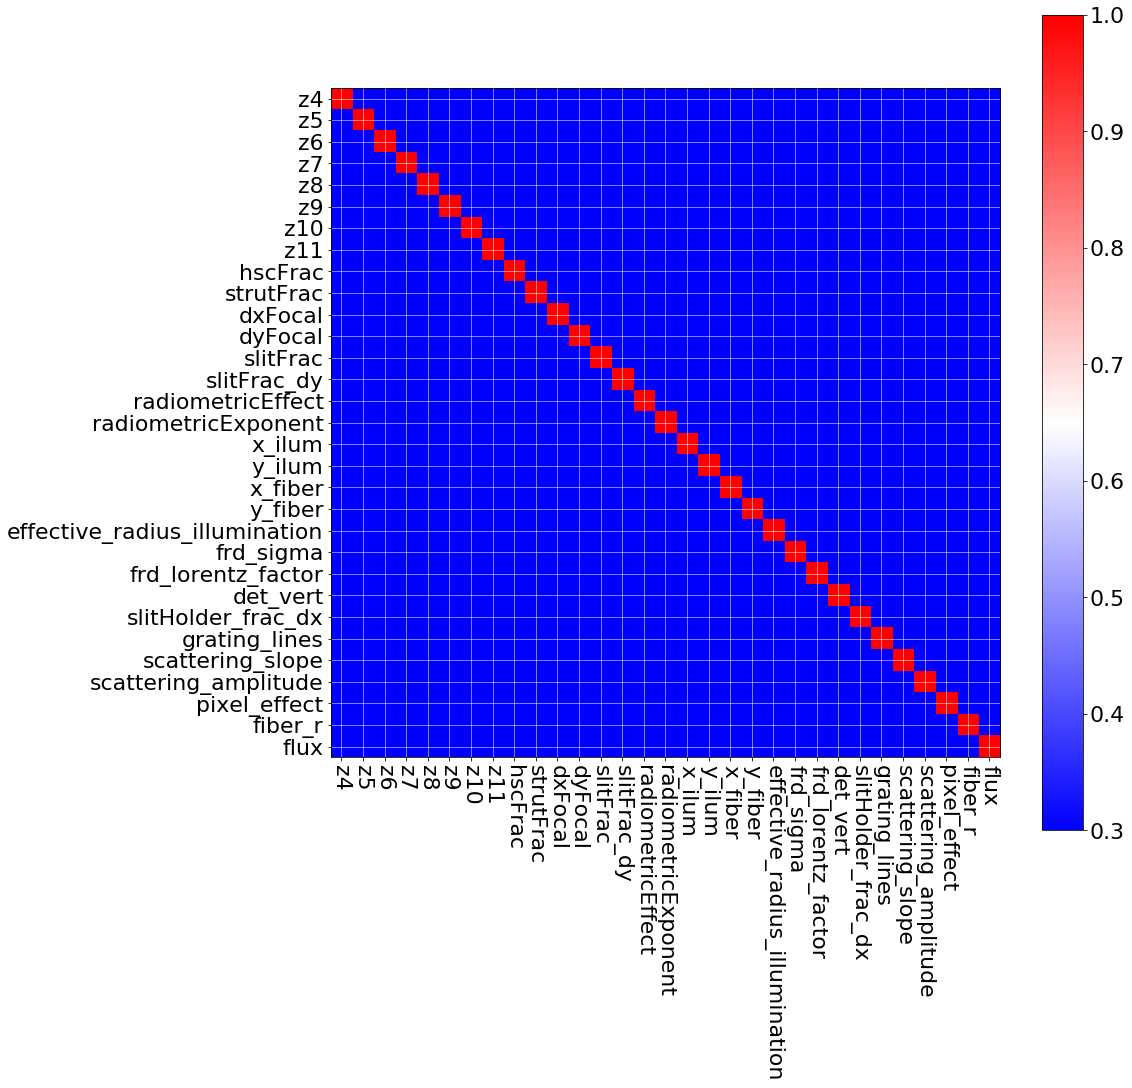

In [962]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(pearsonr_full_chain),vmin=0.3,vmax=1,cmap='bwr')
ax = plt.gca();
ax.set_yticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_yticklabels(columns,rotation=0);
ax.set_xticks(range(np.shape(chain0_Emcee3_reshaped)[1]))
ax.set_xticklabels(columns,rotation=-90);
ax.grid(color='w', linestyle='-', linewidth=0.5)
plt.colorbar()